## Importing the dependencies

In [8]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score

from statsmodels.tsa.arima.model import ARIMA

## Loading and Preprocessing Datasets

In [9]:
hydro = pd.read_csv('US_Geo_Hydro.csv')
solar = pd.read_csv('US_Solar.csv')
wind = pd.read_csv('US_Wind.csv')

In [3]:

for df in (hydro, solar, wind):
    df.rename(columns={
        'area_developable_sq_km': 'area',
        'capacity_ac_mw'        : 'capacity'
    }, inplace=True)

# Tag each with its energy type
hydro['energy_type'] = 'Hydro'
solar['energy_type'] = 'Solar'
wind ['energy_type'] = 'Wind'

# Combine
combined_df = pd.concat([hydro, solar, wind], ignore_index=True).dropna(subset=['latitude','longitude','area','capacity'])

print(combined_df[['energy_type','latitude','longitude','area','capacity']].head())


  energy_type   latitude   longitude       area   capacity
0       Hydro  48.856865 -105.555569   5.633064  13.353907
1       Hydro  48.866631 -105.390266  30.681261  73.433174
2       Hydro  48.876228 -105.224905   5.100894  12.053098
3       Hydro  48.978116 -103.236463   0.025515   0.059774
4       Hydro  48.999749 -102.738285   0.002025   0.004813


C:\Users\km307\AppData\Local\Temp\ipykernel_16280\78036993.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


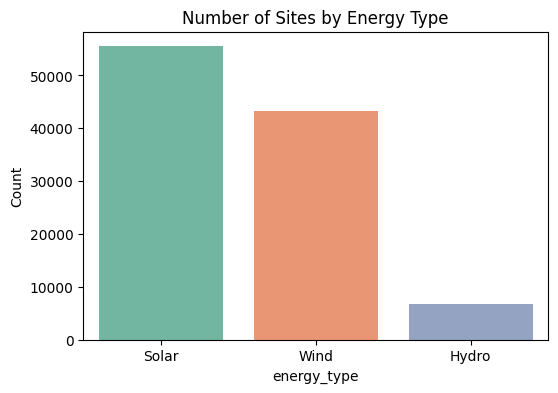

In [4]:
plt.figure(figsize=(6,4))
sns.countplot(
    data=combined_df,
    x='energy_type',
    order=combined_df['energy_type'].value_counts().index,
    palette='Set2'
)
plt.title("Number of Sites by Energy Type")
plt.ylabel("Count")
plt.show()


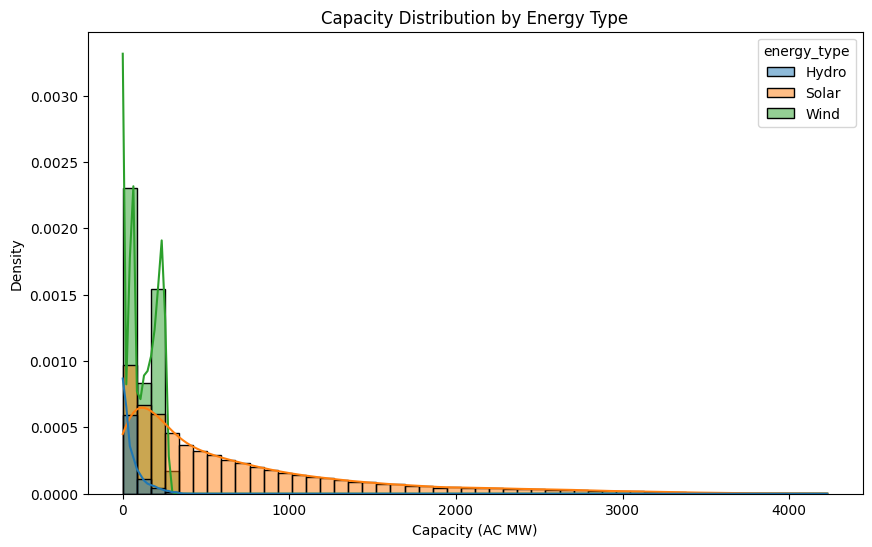

In [5]:
plt.figure(figsize=(10,6))
sns.histplot(
    data=combined_df,
    x='capacity',
    hue='energy_type',
    bins=50, kde=True, stat='density'
)
plt.title("Capacity Distribution by Energy Type")
plt.xlabel("Capacity (AC MW)")
plt.ylabel("Density")
plt.show()


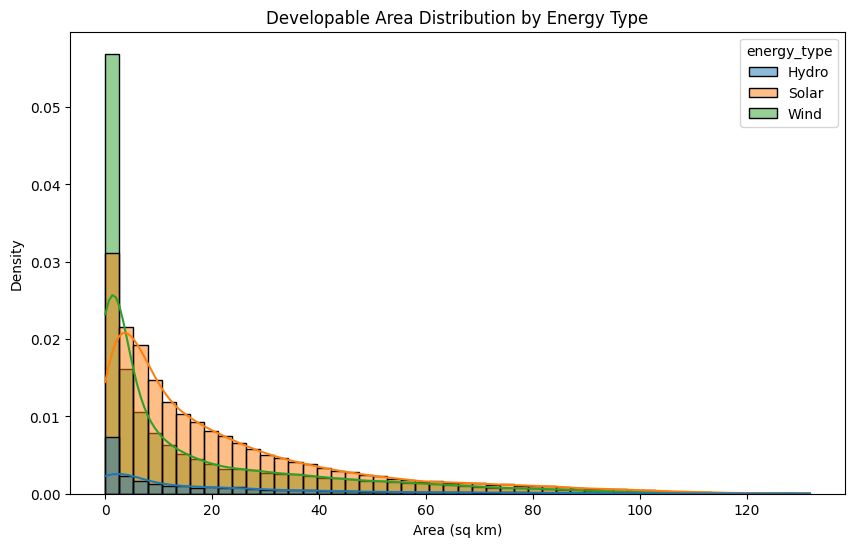

In [6]:
plt.figure(figsize=(10,6))
sns.histplot(
    data=combined_df,
    x='area',
    hue='energy_type',
    bins=50, kde=True, stat='density'
)
plt.title("Developable Area Distribution by Energy Type")
plt.xlabel("Area (sq km)")
plt.ylabel("Density")
plt.show()


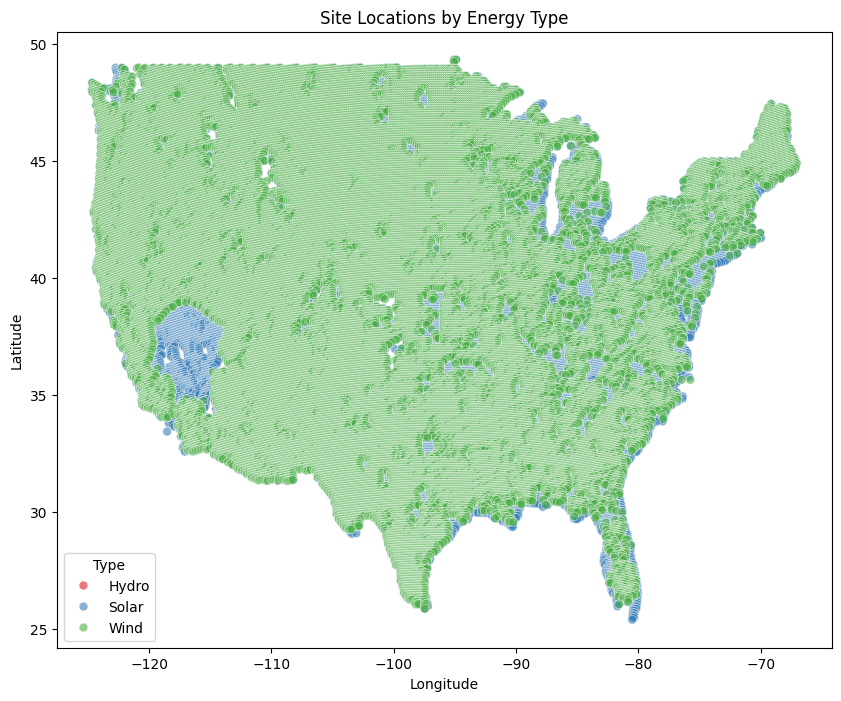

In [7]:
plt.figure(figsize=(10,8))
sns.scatterplot(
    data=combined_df,
    x='longitude', y='latitude',
    hue='energy_type',
    palette='Set1', alpha=0.6, s=40
)
plt.title("Site Locations by Energy Type")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Type")
plt.show()


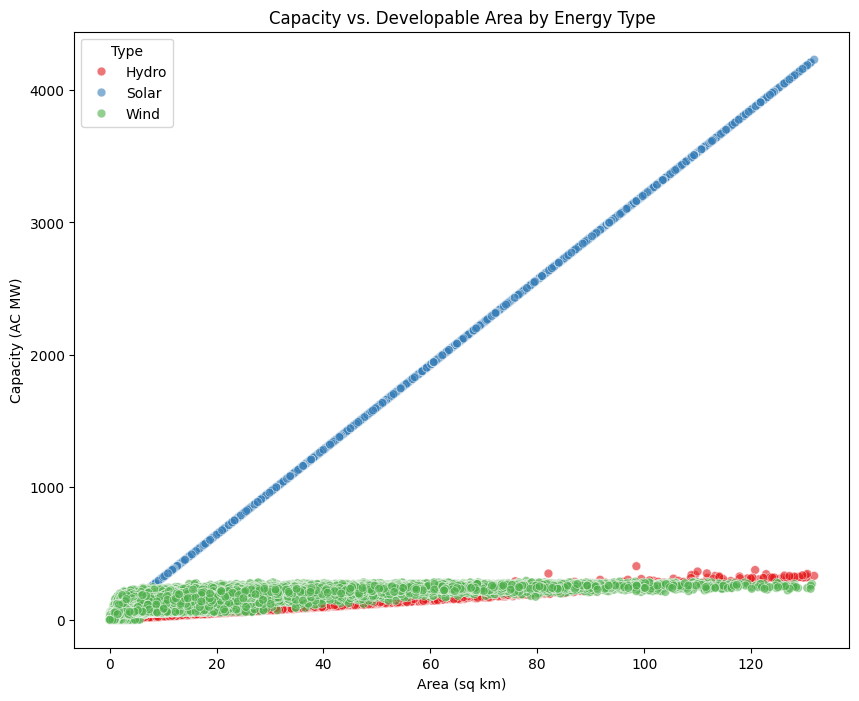

In [8]:
plt.figure(figsize=(10,8))
sns.scatterplot(
    data=combined_df,
    x='area', y='capacity',
    hue='energy_type',
    palette='Set1',
    alpha=0.6, s=40
)
plt.title("Capacity vs. Developable Area by Energy Type")
plt.xlabel("Area (sq km)")
plt.ylabel("Capacity (AC MW)")
plt.legend(title="Type")
plt.show()


As the solar coverage area increases, the throughput will also increase as the linear relation shows.
This is not the case for hydro and wind.

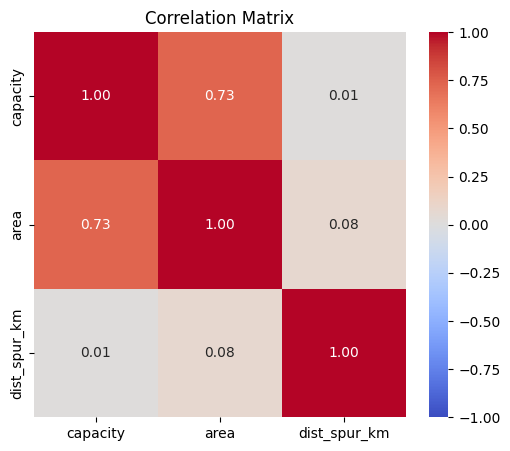

In [9]:
num_cols = ['capacity','area','dist_spur_km']
corr_df = combined_df[num_cols].dropna().corr()

plt.figure(figsize=(6,5))
sns.heatmap(
    corr_df, annot=True, cmap='coolwarm', fmt=".2f",
    vmin=-1, vmax=1
)
plt.title("Correlation Matrix")
plt.show()


The coorelation between area and capacity could be affected by solar energy.

### Upsampling and Balancing data

In [10]:
target_rows = 60000

def upsample_df(df, target_rows):
    if len(df) >= target_rows:
        return df.sample(target_rows, replace=False, random_state=42).reset_index(drop=True)
    else:
        return df.sample(target_rows, replace=True, random_state=42).reset_index(drop=True)

# Apply upsampling
hydro_upsampled = upsample_df(hydro, target_rows)
solar_upsampled = upsample_df(solar, target_rows)
wind_upsampled = upsample_df(wind, target_rows)

# Save the new datasets
#hydro_upsampled.to_csv("USHydro.csv", index=False)
#solar_upsampled.to_csv("USSolar.csv", index=False)
#wind_upsampled.to_csv("USWind.csv", index=False)

# Print confirmation
print("Upsampled datasets:")
print("Hydro:", hydro_upsampled.shape)
print("Solar:", solar_upsampled.shape)
print("Wind:", wind_upsampled.shape)


Upsampled datasets:
Hydro: (60000, 7)
Solar: (60000, 10)
Wind: (60000, 11)


## Combining Datasets

In [11]:
# -------------------------------
# 1. Add Energy Type Identifiers
# -------------------------------
hydro_upsampled['energy_type'] = 'Hydro'
solar_upsampled['energy_type'] = 'Solar'
wind_upsampled['energy_type'] = 'Wind'

# -------------------------------
# 2. Normalize Column Names
# -------------------------------
for df in [hydro_upsampled, solar_upsampled, wind_upsampled]:
    df['capacity'] = df['capacity_ac_mw']
    df['area'] = df['area_developable_sq_km'] if 'area_developable_sq_km' in df.columns else 0
    
# -------------------------------
# 3. Add Elevation and Resource Columns (Fill with 0 if missing)
# -------------------------------

hydro_upsampled['elevation_m'] = 0
hydro_upsampled['resource'] = 0

# For solar and wind, add elevation/resource if missing
for df in [solar_upsampled, wind_upsampled]:
    if 'elevation_m' not in df.columns:
        df['elevation_m'] = 0
    else:
        df['elevation_m'].fillna(0, inplace=True)
        
    if 'resource' not in df.columns:
        df['resource'] = 0
    else:
        df['resource'].fillna(0, inplace=True)

# -------------------------------
# 4. Assign Unique Identifiers
# -------------------------------
for df in [hydro_upsampled, solar_upsampled, wind_upsampled]:
    if 'sc_point_gid' not in df.columns:
        df['sc_point_gid'] = df.index

# -------------------------------
# 5. Define Common Columns
# -------------------------------
common_cols = [
    'sc_point_gid', 'latitude', 'longitude',
    'capacity', 'area', 'energy_type',
    'elevation_m', 'resource'
]

# -------------------------------
# 6. Combine Datasets
# -------------------------------
combined_df = pd.concat([
    hydro_upsampled[common_cols],
    solar_upsampled[common_cols],
    wind_upsampled[common_cols]
], axis=0, ignore_index=True)

# -------------------------------
# 7. Shuffle Dataset
# -------------------------------
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nSample of combined dataset:")
combined_df.head()


Sample of combined dataset:


C:\Users\km307\AppData\Local\Temp\ipykernel_21348\3665754901.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['elevation_m'].fillna(0, inplace=True)
C:\Users\km307\AppData\Local\Temp\ipykernel_21348\3665754901.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

sc_point_gid   latitude   longitude    capacity      area energy_type  \
0         67492  33.885790  -91.075710    0.000000  0.198000        Wind   
1          9571  47.556362 -116.187850    0.000000  0.211500        Wind   
2         17508  44.555383 -121.989046   12.706543  4.827708       Hydro   
3         41190  40.601764 -102.431902    0.436447  0.182214       Hydro   
4         31736  43.186130  -95.762040  123.436243  3.846619       Solar   

   elevation_m  resource  
0      45.5000  6.729780  
1     856.6667  4.956268  
2       0.0000  0.000000  
3       0.0000  0.000000  
4     436.1250  4.109127

In [12]:
print("\nEnergy type counts:")
print(combined_df['energy_type'].value_counts())

print("\nMissing values per column:")
print(combined_df.isnull().sum())


Energy type counts:
energy_type
Wind     60000
Hydro    60000
Solar    60000
Name: count, dtype: int64

Missing values per column:
sc_point_gid    0
latitude        0
longitude       0
capacity        0
area            0
energy_type     0
elevation_m     0
resource        0
dtype: int64


In [13]:
print("Combined Dataset Summary Statistics:")
combined_df.describe()

Combined Dataset Summary Statistics:


sc_point_gid       latitude      longitude       capacity  \
count  180000.000000  180000.000000  180000.000000  180000.000000   
mean    46325.141056      38.692883    -102.697717     290.501413   
std     21934.761920       5.445864      12.477974     527.988952   
min       796.000000      25.487381    -124.662796       0.000000   
25%     28167.750000      33.825464    -112.670760      21.266637   
50%     44733.000000      39.071062    -104.249167     102.000000   
75%     65638.250000      43.019478     -94.192930     246.000000   
max     98222.000000      49.332330     -67.070724    4208.739787   

                area    elevation_m       resource  
count  180000.000000  180000.000000  180000.000000  
mean       19.668666     530.450186       3.785063  
std        23.852724     676.371622       2.929114  
min         0.000405     -71.000000       0.000000  
25%         2.117700       0.000000       0.000000  
50%         9.955408     241.183333       4.466247  
75%        28.635302     856.694469       6.036443  
max       131.798137    3131.000000      12.130080

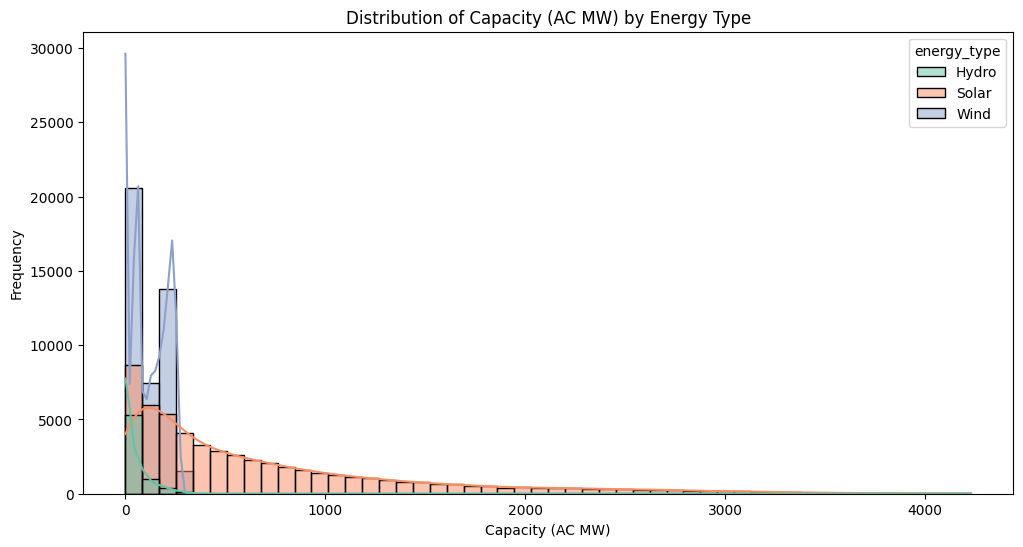

In [14]:
plt.figure(figsize=(12, 6))
sns.histplot(data=combined_df, x='capacity', hue='energy_type', bins=50, kde=True, palette='Set2')
plt.title("Distribution of Capacity (AC MW) by Energy Type")
plt.xlabel("Capacity (AC MW)")
plt.ylabel("Frequency")
plt.show()

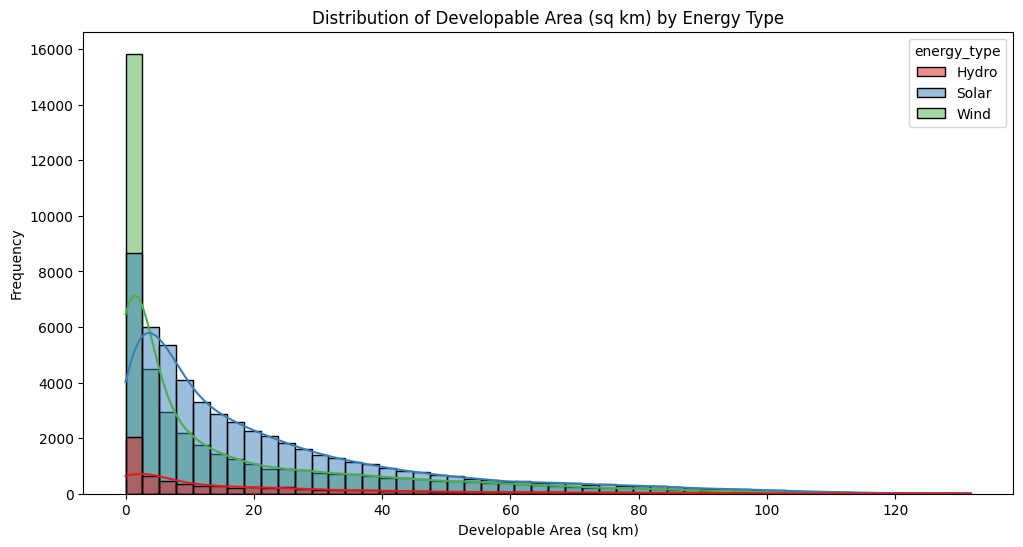

In [15]:
# Plot distribution (histogram) of developable area.
plt.figure(figsize=(12, 6))
sns.histplot(data=combined_df, x='area', hue='energy_type', bins=50, kde=True, palette='Set1')
plt.title("Distribution of Developable Area (sq km) by Energy Type")
plt.xlabel("Developable Area (sq km)")
plt.ylabel("Frequency")
plt.show()

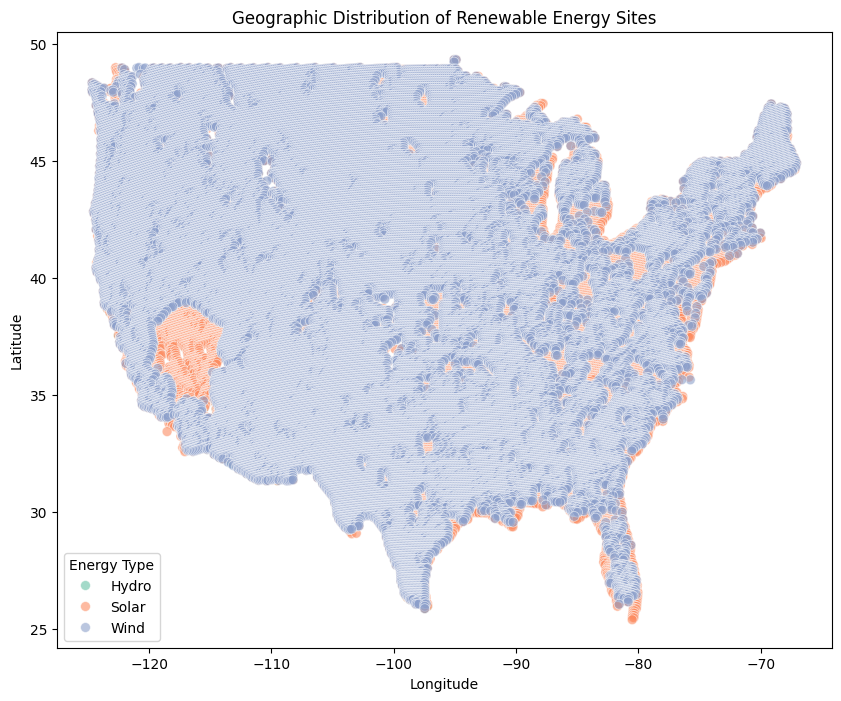

In [16]:
# Scatter plot of renewable energy sites using latitude and longitude.
plt.figure(figsize=(10, 8))
sns.scatterplot(data=combined_df, x='longitude', y='latitude', hue='energy_type', palette='Set2', alpha=0.6, s=50)
plt.title("Geographic Distribution of Renewable Energy Sites")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Energy Type")
plt.show()


Hydro energy is more concentrated in the areas with water bodies, whereas solar and wind are more distributed.

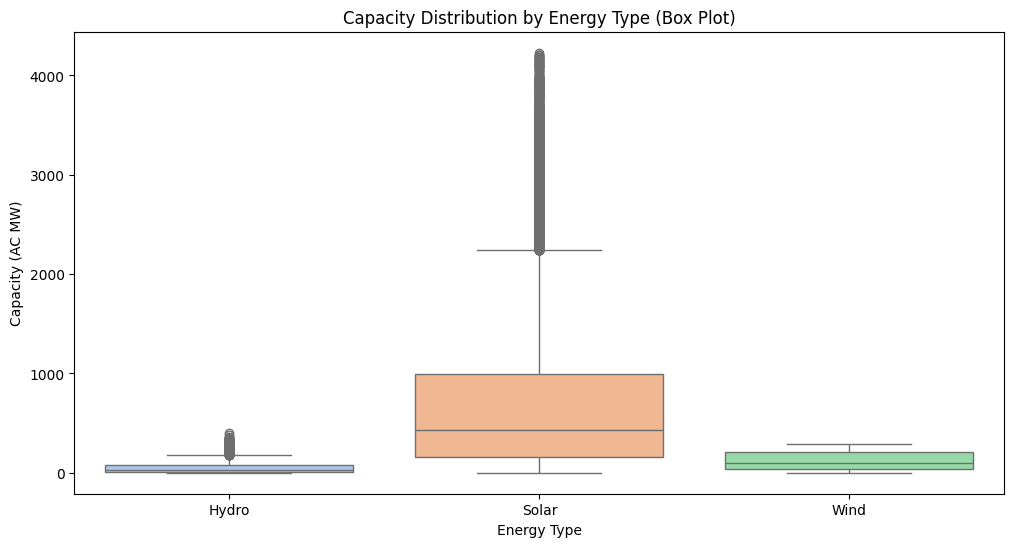

In [17]:
# %% [code]
plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_df, x='energy_type', y='capacity', hue='energy_type', palette='pastel')
plt.title("Capacity Distribution by Energy Type (Box Plot)")
plt.xlabel("Energy Type")
plt.ylabel("Capacity (AC MW)")
plt.show()


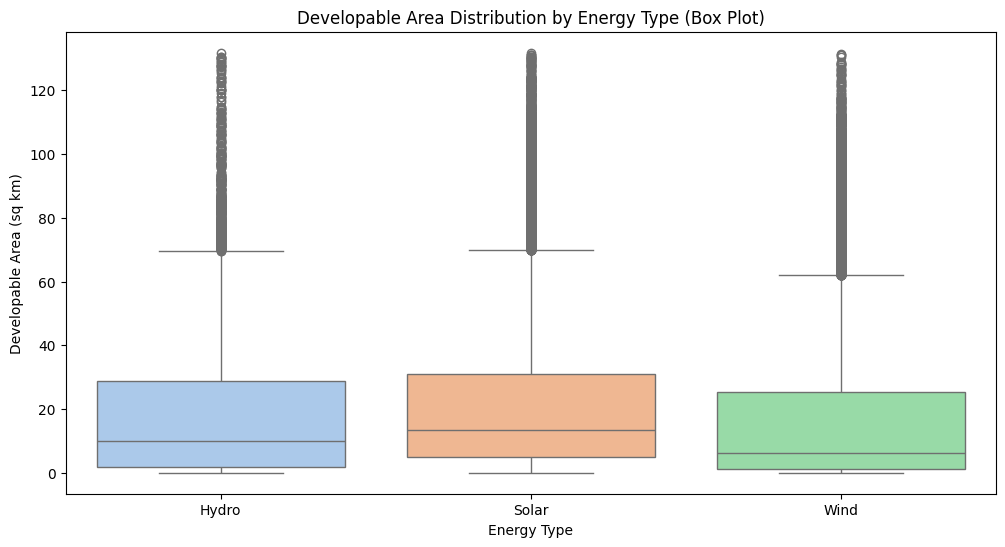

In [18]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_df, x='energy_type', y='area', hue='energy_type',palette='pastel')
plt.title("Developable Area Distribution by Energy Type (Box Plot)")
plt.xlabel("Energy Type")
plt.ylabel("Developable Area (sq km)")
plt.show()

Most of the developable area is between 20 square km.
The outliers can be due to different terrarian, as some might have major solar, wind or hydro plants.

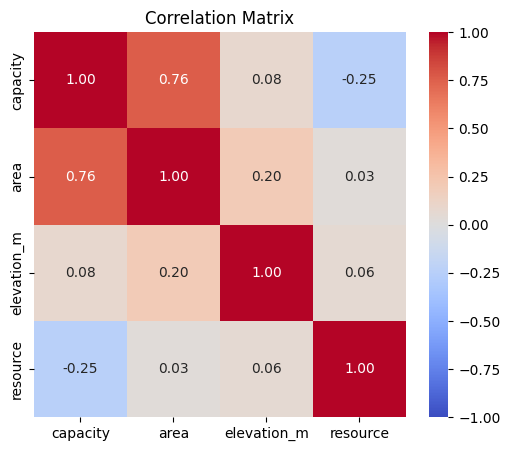

In [19]:

num_cols = ['capacity','area', 'elevation_m', 'resource']
corr_df = combined_df[num_cols].dropna().corr()

plt.figure(figsize=(6,5))
sns.heatmap(
    corr_df, annot=True, cmap='coolwarm', fmt=".2f",
    vmin=-1, vmax=1
)
plt.title("Correlation Matrix")
plt.show()


## Analysis 

TOPSIS ranking (top 5 sites):
         latitude   longitude     capacity        area  topsis_score
166676  37.425550 -116.478910  4208.739787  131.156102      0.998166
116093  32.507206 -113.763430  4207.844517  131.128203      0.998076
160651  32.507206 -113.763430  4207.844517  131.128203      0.998076
73282   33.628807 -106.648926  4188.600651  130.528510      0.994272
39743   33.738000 -106.533690  4180.322131  130.270528      0.992373
MOORA ranking (top 5 sites):
         latitude   longitude     capacity        area  moora_score
166676  37.425550 -116.478910  4208.739787  131.156102     0.000063
160651  32.507206 -113.763430  4207.844517  131.128203     0.000063
116093  32.507206 -113.763430  4207.844517  131.128203     0.000063
73282   33.628807 -106.648926  4188.600651  130.528510     0.000063
39743   33.738000 -106.533690  4180.322131  130.270528     0.000063
AHP derived criteria weights: [0.66666667 0.33333333]
Hybrid AHP-TOPSIS ranking (top 5 sites):
         latitude   long

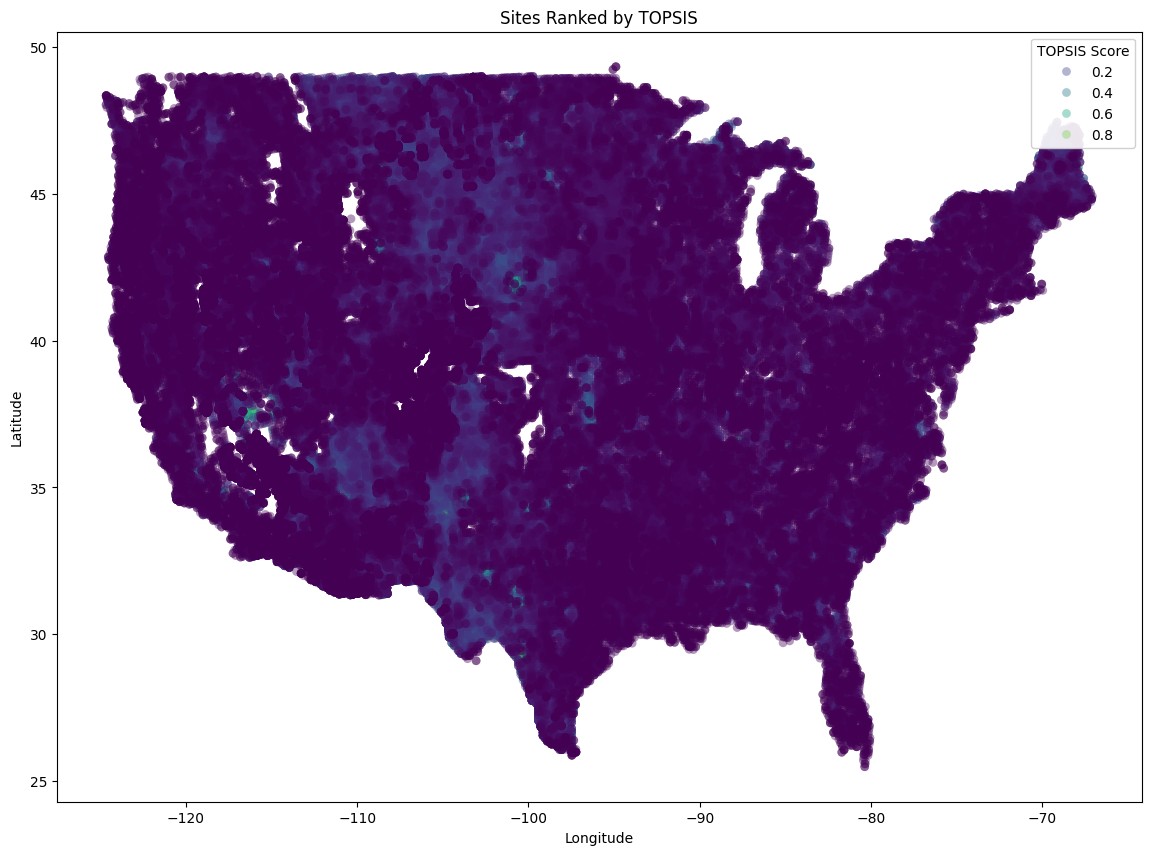

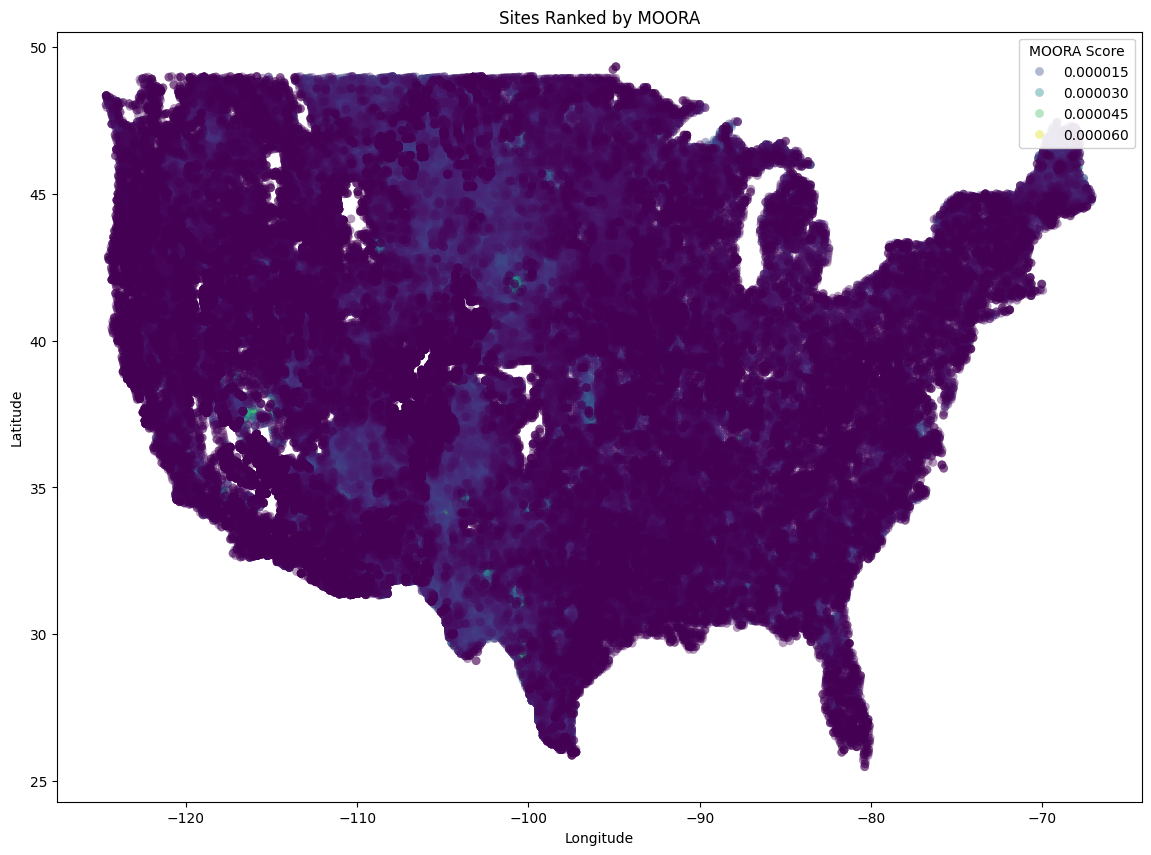

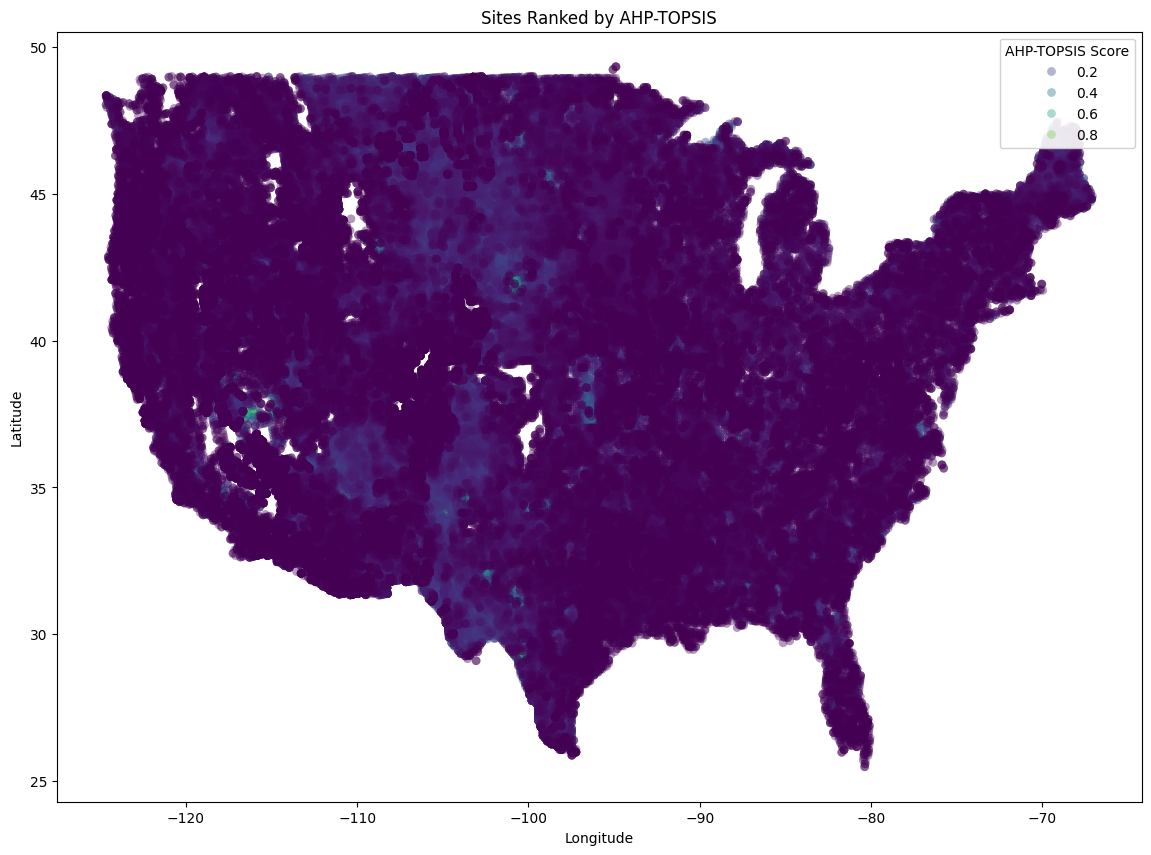

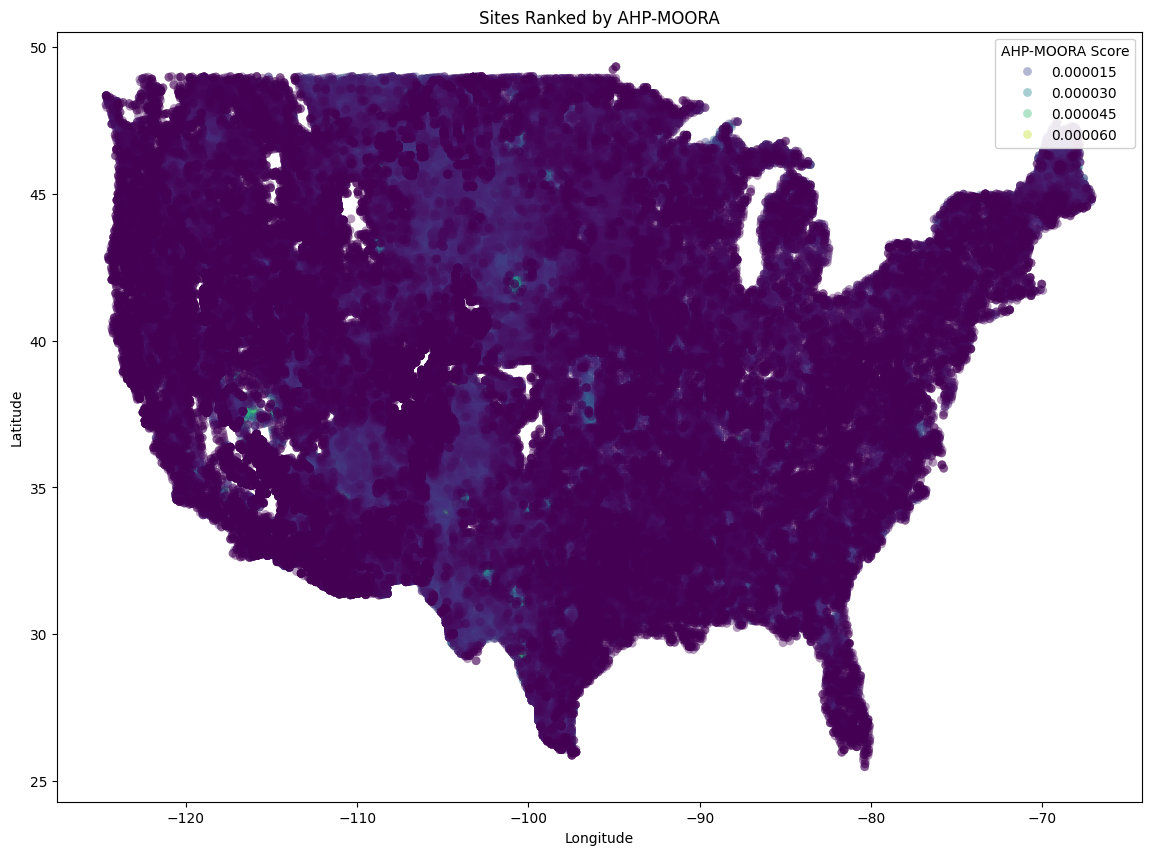

In [41]:
# 1. Define functions

# TOPSIS IMPLEMENTATION 
def topsis(decision_matrix, weights, criteria):
    
    # Normalize the decision matrix using Euclidean norm.
    norm_matrix = decision_matrix.apply(lambda col: col / np.sqrt((col**2).sum()), axis=0)
    
    # Multiply by weights.
    weighted_matrix = norm_matrix * weights
    
    # Determine the ideal best and worst.
    ideal_best = {}
    ideal_worst = {}
    for col, crit in zip(weighted_matrix.columns, criteria):
        if crit == 1:  # Beneficial criterion
            ideal_best[col] = weighted_matrix[col].max()
            ideal_worst[col] = weighted_matrix[col].min()
        else:  # Non-beneficial criterion
            ideal_best[col] = weighted_matrix[col].min()
            ideal_worst[col] = weighted_matrix[col].max()
    
    # Calculate distances from the ideal best and worst.
    diff_best = weighted_matrix - pd.Series(ideal_best)
    diff_worst = weighted_matrix - pd.Series(ideal_worst)
    distance_best = diff_best.pow(2).sum(axis=1).apply(np.sqrt)
    distance_worst = diff_worst.pow(2).sum(axis=1).apply(np.sqrt)
    
    # Closeness coefficient
    cc = distance_worst / (distance_best + distance_worst)
    return cc


# Considering 'capacity' and 'area' as beneficial criteria.
decision_data = combined_df[['capacity', 'area']]
# We are cosidering weights for capacity and area as 0.6 and 0.4 respectively.
weights = np.array([0.6, 0.4])
# Both criteria are beneficial: 1 means more is better.
criteria = [1, 1]

combined_df['topsis_score'] = topsis(decision_data, weights, criteria)
combined_df.sort_values('topsis_score', ascending=False, inplace=True)
print("TOPSIS ranking (top 5 sites):")
print(combined_df[['latitude', 'longitude', 'capacity', 'area', 'topsis_score']].head())


# MOORA IMPLEMENTATION
def moora(decision_matrix, weights, criteria):
    
    # Normalize the decision matrix by dividing by the sum of absolute values for each column.
    norm_matrix = decision_matrix / decision_matrix.abs().sum()
    weighted_matrix = norm_matrix * weights
    
    # For beneficial criteria add the score; for non-beneficial subtract the score.
    beneficial = weighted_matrix.loc[:, [c for c, crit in zip(weighted_matrix.columns, criteria) if crit == 1]]
    non_beneficial = weighted_matrix.loc[:, [c for c, crit in zip(weighted_matrix.columns, criteria) if crit == -1]]
    
    # When all criteria are beneficial, non_beneficial will be empty.
    score = weighted_matrix.sum(axis=1)
    if not non_beneficial.empty:
        score = beneficial.sum(axis=1) - non_beneficial.sum(axis=1)
    return score

# Considering 'capacity' and 'area' as beneficial criteria.
moora_scores = moora(decision_data, weights, criteria)
combined_df['moora_score'] = moora_scores
combined_df.sort_values('moora_score', ascending=False, inplace=True)
print("MOORA ranking (top 5 sites):")
print(combined_df[['latitude', 'longitude', 'capacity', 'area', 'moora_score']].head())


# HYBRID AHP-TOPSIS AND AHP-MOORA
def ahp_weights(pairwise_matrix):
    
    eigvals, eigvecs = np.linalg.eig(pairwise_matrix)
    max_index = np.argmax(eigvals.real)
    weights = np.abs(eigvecs[:, max_index].real)
    return weights / weights.sum()

# AHP weights for criteria: here we assume a pairwise comparison matrix.
# We are assuming that 'capacity' is twice as important as 'area'.
pairwise = np.array([[1,    2],
                     [1/2,  1]])
criteria_weights = ahp_weights(pairwise)
print("AHP derived criteria weights:", criteria_weights)

# Using the weights from AHP for TOPSIS and MOORA
# --- AHP-TOPSIS scoring ---
combined_df['ahp_topsis_score'] = topsis(decision_data, criteria_weights, [1, 1])
combined_df.sort_values('ahp_topsis_score', ascending=False, inplace=True)
print("Hybrid AHP-TOPSIS ranking (top 5 sites):")
print(combined_df[['latitude', 'longitude', 'capacity', 'area', 'ahp_topsis_score']].head())
print("\n")
# --- AHP-MOORA scoring ---
combined_df['ahp_moora_score'] = moora(decision_data, criteria_weights, criteria)
combined_df.sort_values('ahp_moora_score', ascending=False, inplace=True)
print("AHP-MOORA ranking (top 5 sites):")
print(combined_df[['latitude', 'longitude', 'capacity', 'area', 'ahp_moora_score']].head())


# 2. Prepare data & parameters
decision_data = combined_df[['capacity','area']]
criteria = [1,1]
weights     = np.array([0.6,0.4])

# 3. Compute plain scores 
combined_df['topsis_score'] = topsis(decision_data, weights, criteria)
combined_df['moora_score']  = moora(decision_data, weights, criteria)

# 4. Derive AHP weights & compute hybrid scores
pairwise = np.array([[1,2],[1/2,1]])
ahp_wts  = ahp_weights(pairwise)
combined_df['ahp_topsis_score'] = topsis(decision_data, ahp_wts, criteria)
combined_df['ahp_moora_score']  = moora(decision_data, ahp_wts, criteria)

# 5. Print top-5 for each (sorting only for display)
print("TOPSIS top-5:")
print(combined_df.sort_values('topsis_score', ascending=False)
               [['latitude','longitude','topsis_score']].head())

print("\nMOORA top-5:")
print(combined_df.sort_values('moora_score', ascending=False)
               [['latitude','longitude','moora_score']].head())

print("\nAHP-TOPSIS top-5:")
print(combined_df.sort_values('ahp_topsis_score', ascending=False)
               [['latitude','longitude','ahp_topsis_score']].head())

print("\nAHP-MOORA top-5:")
print(combined_df.sort_values('ahp_moora_score', ascending=False)
               [['latitude','longitude','ahp_moora_score']].head())

# 6. Plot all four maps in sequence
import matplotlib.pyplot as plt
import seaborn as sns

for score_col, title in [
    ('topsis_score',      'TOPSIS'),
    ('moora_score',       'MOORA'),
    ('ahp_topsis_score',  'AHP-TOPSIS'),
    ('ahp_moora_score',   'AHP-MOORA')
]:
    plt.figure(figsize=(14,10))
    sns.scatterplot(
        data=combined_df,
        x='longitude', y='latitude',
        hue=score_col,
        palette='viridis',
        s=40, alpha=0.4, linewidth=0
    )
    plt.title(f"Sites Ranked by {title}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend(title=f'{title} Score', loc='upper right', framealpha=0.9)
    plt.show()


## Encoding and Scaling

In [14]:
# Select features and target for renewable type classification.
X_type = combined_df[['latitude', 'longitude', 'area', 'elevation_m', 'resource']].values
y_type = combined_df['energy_type'].values

# Encode the string labels into numbers.
label_encoder = LabelEncoder()
y_type_enc = label_encoder.fit_transform(y_type)
print("Encoded energy types:", np.unique(y_type_enc))

# Split dataset.
X_train_type, X_test_type, y_train_type, y_test_type = train_test_split(X_type, y_type_enc, test_size=0.2, random_state=42)

# Scale the features.
scaler_type = StandardScaler()
X_train_type_scaled = scaler_type.fit_transform(X_train_type)
X_test_type_scaled = scaler_type.transform(X_test_type)


Encoded energy types: [0 1 2]


# Classification 

### By Source Type

1. Logistic Regression -

Logistic Regression Accuracy: 0.94325


<Axes: >

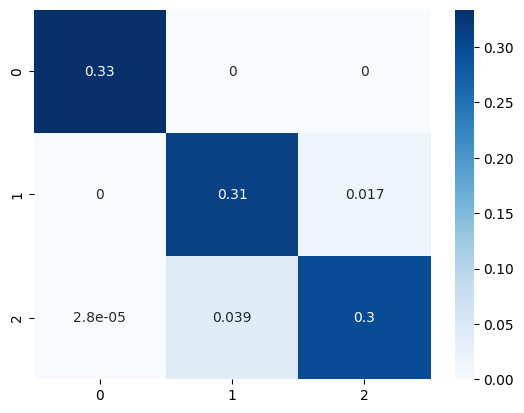

In [16]:

from sklearn.linear_model import LogisticRegression

model_logreg = LogisticRegression(max_iter=1000)
model_logreg.fit(X_train_type_scaled, y_train_type)

y_pred_logreg = model_logreg.predict(X_test_type_scaled)

print("Logistic Regression Accuracy:", accuracy_score(y_test_type, y_pred_logreg))
cf_type_log = confusion_matrix(y_test_type, y_pred_logreg)
sns.heatmap(cf_type_log/np.sum(cf_type_log), annot=True, cmap='Blues')


Decision Tree Classifier Accuracy: 0.9936111111111111


<Axes: >

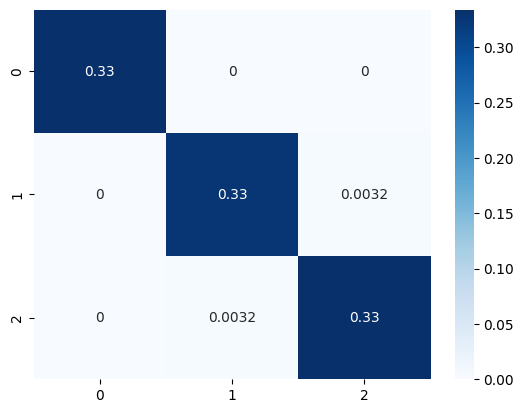

In [21]:

from sklearn.tree import DecisionTreeClassifier

model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(X_train_type_scaled, y_train_type)

y_pred_dt = model_dt.predict(X_test_type_scaled)

print("Decision Tree Classifier Accuracy:", accuracy_score(y_test_type, y_pred_dt))

cf_type_dt = confusion_matrix(y_test_type, y_pred_dt)
sns.heatmap(cf_type_dt/np.sum(cf_type_dt), annot=True, cmap='Blues')


Random Forest Classifier Accuracy: 0.9958333333333333


<Axes: >

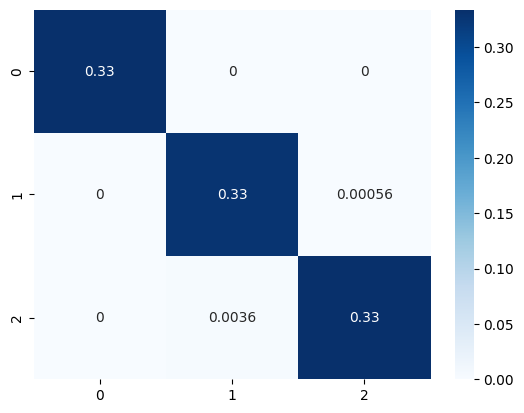

In [18]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train_type_scaled, y_train_type)

y_pred_rf = model_rf.predict(X_test_type_scaled)

print("Random Forest Classifier Accuracy:", accuracy_score(y_test_type, y_pred_rf))

cf_type_rf = confusion_matrix(y_test_type, y_pred_rf)
sns.heatmap(cf_type_rf/np.sum(cf_type_rf), annot=True, cmap='Blues')


SVM Classifier Accuracy: 0.9643611111111111


<Axes: >

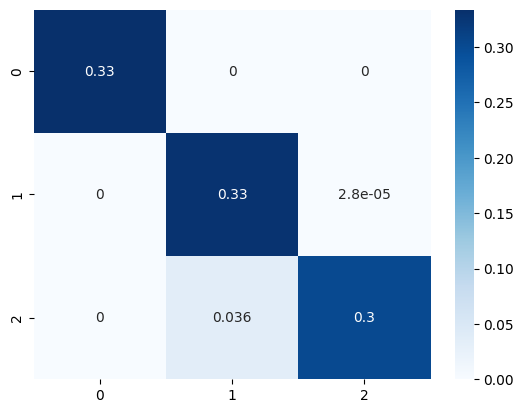

In [19]:
from sklearn.svm import SVC


model_svm = SVC(kernel='rbf', random_state=42)  
model_svm.fit(X_train_type_scaled, y_train_type)

y_pred_svm = model_svm.predict(X_test_type_scaled)

print("SVM Classifier Accuracy:", accuracy_score(y_test_type, y_pred_svm))

cf_type_svm = confusion_matrix(y_test_type, y_pred_svm)
sns.heatmap(cf_type_svm/np.sum(cf_type_svm), annot=True, cmap='Blues')

KNN Classifier Accuracy: 0.987


Text(0.5, 1.0, 'KNN Confusion Matrix (Normalized)')

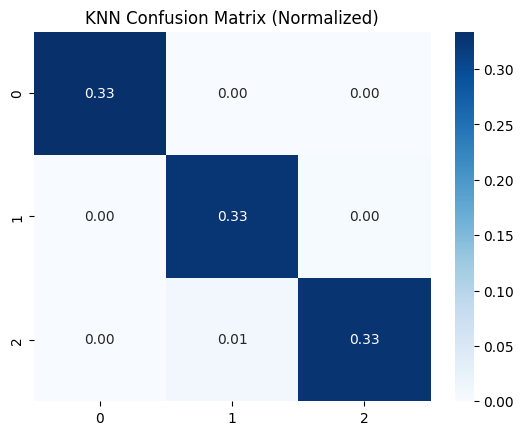

In [20]:

from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier(n_neighbors=3)
model_knn.fit(X_train_type_scaled, y_train_type)

y_pred_knn = model_knn.predict(X_test_type_scaled)

print("KNN Classifier Accuracy:", accuracy_score(y_test_type, y_pred_knn))

cf_type_knn = confusion_matrix(y_test_type, y_pred_knn)
sns.heatmap(cf_type_knn / np.sum(cf_type_knn), annot=True, cmap='Blues', fmt='.2f')
plt.title("KNN Confusion Matrix (Normalized)")


6. LSTM

c:\Users\km307\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,443 (21.26 KB)

 Trainable params: 5,443 (21.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9238 - loss: 0.2413 - val_accuracy: 0.9768 - val_loss: 0.0617
Epoch 2/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9812 - loss: 0.0548 - val_accuracy: 0.9798 - val_loss: 0.0544
Epoch 3/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9839 - loss: 0.0469 - val_accuracy: 0.9816 - val_loss: 0.0533
Epoch 4/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9840 - loss: 0.0457 - val_accuracy: 0.9843 - val_loss: 0.0460
Epoch 5/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9845 - loss: 0.0437 - val_accuracy: 0.9834 - val_loss: 0.0477
Epoch 6/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9848 - loss: 0.0438 - val_accuracy: 0.9836 - val_loss: 0.0486
Epoch 7/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9843 - loss: 0.0441 - val_accuracy: 0.9836 - val_loss: 0.0484
Epoch 8/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9851 - loss: 0

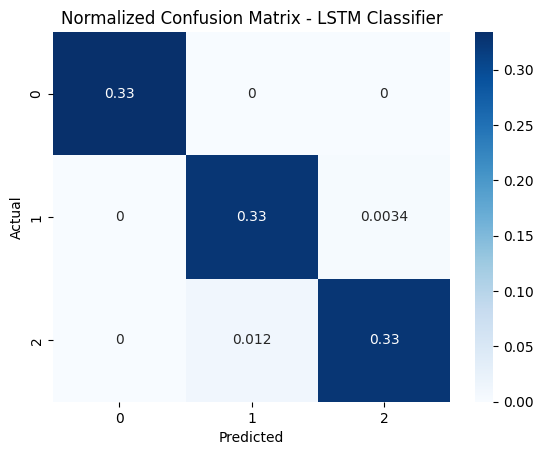

In [9]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix

# --- Reshape the scaled input data for LSTM ---
X_train_lstm = X_train_type_scaled.reshape((X_train_type_scaled.shape[0], 1, X_train_type_scaled.shape[1]))
X_test_lstm = X_test_type_scaled.reshape((X_test_type_scaled.shape[0], 1, X_test_type_scaled.shape[1]))

# --- Convert labels to categorical for softmax ---
y_train_lstm = to_categorical(y_train_type, num_classes=3)
y_test_lstm = to_categorical(y_test_type, num_classes=3)

# --- Build the LSTM Classifier ---
model_lstm = Sequential([
    LSTM(32, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')  # 3 classes
])

model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_lstm.summary()

# --- Train the model ---
history_lstm = model_lstm.fit(X_train_lstm, y_train_lstm, epochs=20, 
                              validation_data=(X_test_lstm, y_test_lstm), verbose=1)


y_pred_probs = model_lstm.predict(X_test_lstm)
y_pred_lstm = np.argmax(y_pred_probs, axis=1)
y_true_lstm = np.argmax(y_test_lstm, axis=1)

# --- Accuracy and Confusion Matrix ---
print("LSTM Classifier Accuracy:", accuracy_score(y_true_lstm, y_pred_lstm))

cf_lstm = confusion_matrix(y_true_lstm, y_pred_lstm)
sns.heatmap(cf_lstm / np.sum(cf_lstm), annot=True, cmap='Blues')
plt.title("Normalized Confusion Matrix - LSTM Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


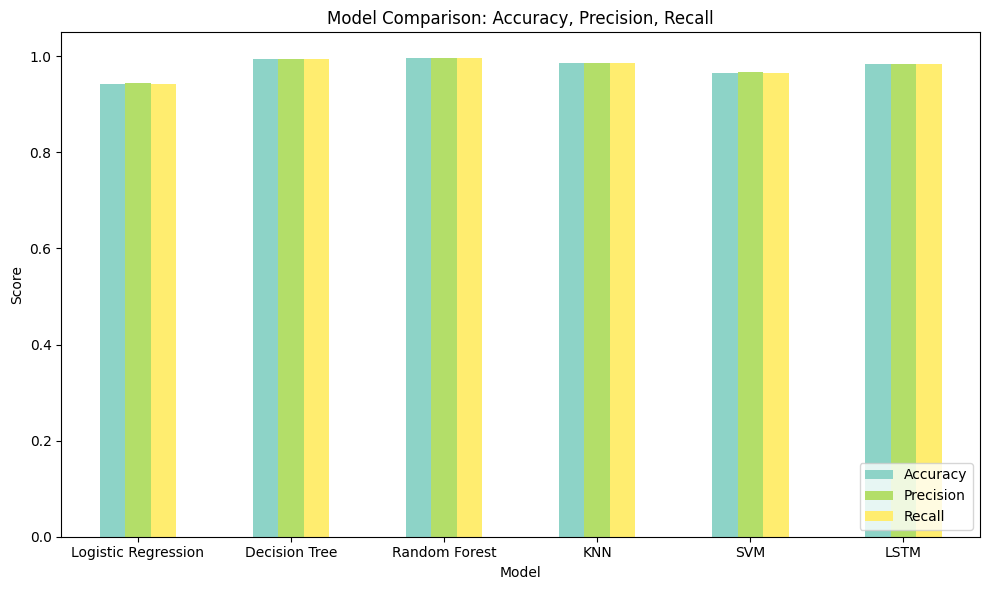

In [22]:
# Calculate metrics
metrics = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'KNN', 'SVM', 'LSTM'],
    'Accuracy': [
        accuracy_score(y_test_type, y_pred_logreg),
        accuracy_score(y_test_type, y_pred_dt),
        accuracy_score(y_test_type, y_pred_rf),
        accuracy_score(y_test_type, y_pred_knn),
        accuracy_score(y_test_type, y_pred_svm),
        accuracy_score(y_test_type, y_pred_lstm)

    ],
    'Precision': [
        precision_score(y_test_type, y_pred_logreg, average='weighted'),
        precision_score(y_test_type, y_pred_dt, average='weighted'),
        precision_score(y_test_type, y_pred_rf, average='weighted'),
        precision_score(y_test_type, y_pred_knn, average='weighted'),
        precision_score(y_test_type, y_pred_svm, average='weighted'),
        precision_score(y_test_type, y_pred_lstm, average='weighted')
    ],
    'Recall': [
        recall_score(y_test_type, y_pred_logreg, average='weighted'),
        recall_score(y_test_type, y_pred_dt, average='weighted'),
        recall_score(y_test_type, y_pred_rf, average='weighted'),
        recall_score(y_test_type, y_pred_knn, average='weighted'),
        recall_score(y_test_type, y_pred_svm, average='weighted'),
        recall_score(y_test_type, y_pred_lstm, average='weighted')
    ]
}

# Create DataFrame for plotting
metrics_df = pd.DataFrame(metrics)
metrics_df.set_index('Model', inplace=True)

# Plot
metrics_df.plot(kind='bar', figsize=(10,6), colormap='Set3')
plt.title("Model Comparison: Accuracy, Precision, Recall")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


### By Potential -

Creating a high_potential column

In [15]:

# For each energy type, assign high potential (1) if capacity is above the median capacity for that type; otherwise, 0.
combined_df['high_potential'] = combined_df.groupby('energy_type')['capacity'].transform(lambda x: (x > x.median()).astype(int))

print("\nHigh Potential counts by Energy Type:")
print(combined_df.groupby('energy_type')['high_potential'].value_counts())



High Potential counts by Energy Type:
energy_type  high_potential
Hydro        0                 30005
             1                 29995
Solar        0                 30001
             1                 29999
Wind         0                 30168
             1                 29832
Name: count, dtype: int64


In [16]:
# One-hot encode the energy_type column.
combined_pot = pd.get_dummies(combined_df, columns=['energy_type'], drop_first=True)

# Define features for potential classification.
feature_cols = ['latitude', 'longitude', 'area', 'elevation_m', 'resource'] + [col for col in combined_pot.columns if col.startswith("energy_type_")]

In [17]:
X_pot = combined_pot[feature_cols].values

# Target column: high_potential (0 or 1)
y_pot = combined_pot['high_potential'].values

print("Features used for potential prediction:", feature_cols)
print("X_pot shape:", X_pot.shape)
print("y_pot value counts:", pd.Series(y_pot).value_counts())

Features used for potential prediction: ['latitude', 'longitude', 'area', 'elevation_m', 'resource', 'energy_type_Solar', 'energy_type_Wind']
X_pot shape: (180000, 7)
y_pot value counts: 0    90174
1    89826
Name: count, dtype: int64


In [18]:
# Split the dataset into train and test sets.
X_train_pot, X_test_pot, y_train_pot, y_test_pot = train_test_split(X_pot, y_pot, test_size=0.2, random_state=42)

# Scale the features.
scaler_pot = StandardScaler()
X_train_pot_scaled = scaler_pot.fit_transform(X_train_pot)
X_test_pot_scaled = scaler_pot.transform(X_test_pot)

print("Train and test splits done for potential prediction.")


Train and test splits done for potential prediction.


1. Logistic Regression

Logistic Regression for Potential Prediction
Accuracy: 0.9638611111111111


<Axes: >

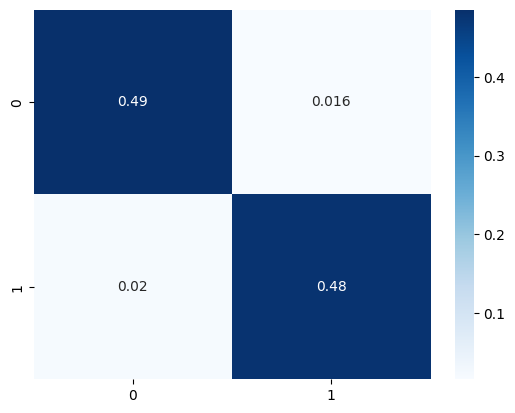

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

model_logreg_pot = LogisticRegression(max_iter=1000)
model_logreg_pot.fit(X_train_pot_scaled, y_train_pot)
y_pred_pot_logreg = model_logreg_pot.predict(X_test_pot_scaled)

print("Logistic Regression for Potential Prediction")
print("Accuracy:", accuracy_score(y_test_pot, y_pred_pot_logreg))
cf_pot_log = confusion_matrix(y_test_pot, y_pred_pot_logreg)
sns.heatmap(cf_pot_log/np.sum(cf_pot_log), annot=True, cmap='Blues')


Decision Tree Classifier for Potential Prediction
Accuracy: 0.9883055555555555


<Axes: >

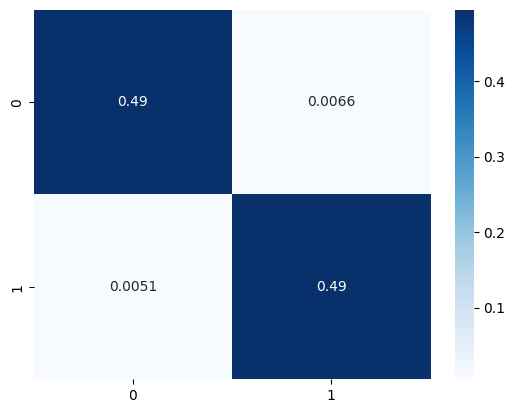

In [25]:
from sklearn.tree import DecisionTreeClassifier

model_dt_pot = DecisionTreeClassifier(random_state=42)
model_dt_pot.fit(X_train_pot_scaled, y_train_pot)
y_pred_pot_dt = model_dt_pot.predict(X_test_pot_scaled)

print("Decision Tree Classifier for Potential Prediction")
print("Accuracy:", accuracy_score(y_test_pot, y_pred_pot_dt))
cf_pot_dt = confusion_matrix(y_test_pot, y_pred_pot_dt)
sns.heatmap(cf_pot_dt/np.sum(cf_pot_dt), annot=True, cmap='Blues')


Random Forest Classifier for Potential Prediction
Accuracy: 0.9912777777777778


<Axes: >

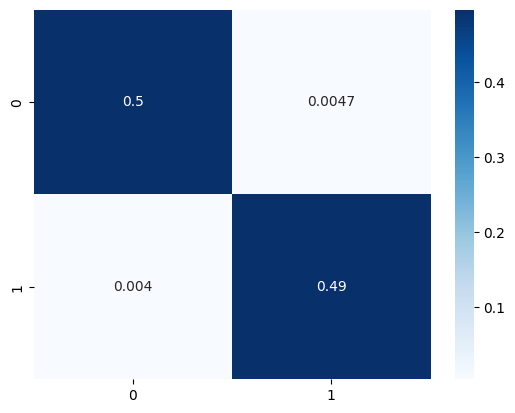

In [20]:
from sklearn.ensemble import RandomForestClassifier

model_rf_pot = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf_pot.fit(X_train_pot_scaled, y_train_pot)
y_pred_pot_rf = model_rf_pot.predict(X_test_pot_scaled)

print("Random Forest Classifier for Potential Prediction")
print("Accuracy:", accuracy_score(y_test_pot, y_pred_pot_rf))
cf_pot_rf = confusion_matrix(y_test_pot, y_pred_pot_rf)
sns.heatmap(cf_pot_rf/np.sum(cf_pot_rf), annot=True, cmap='Blues')


SVM Classifier for Potential Prediction
Accuracy: 0.9694166666666667


<Axes: >

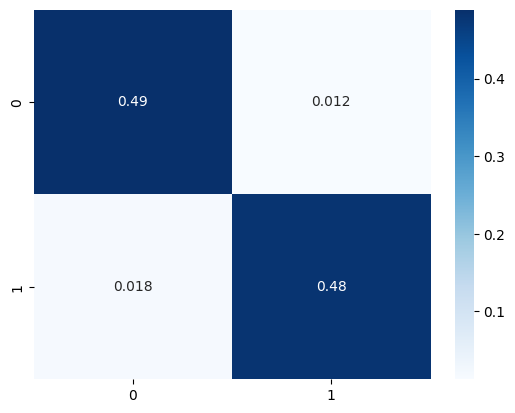

In [21]:
from sklearn.svm import SVC

model_svm_pot = SVC(kernel='rbf', random_state=42)
model_svm_pot.fit(X_train_pot_scaled, y_train_pot)

y_pred_pot_svm = model_svm_pot.predict(X_test_pot_scaled)

print("SVM Classifier for Potential Prediction")
print("Accuracy:", accuracy_score(y_test_pot, y_pred_pot_svm))

cf_pot_svm = confusion_matrix(y_test_pot, y_pred_pot_svm)
sns.heatmap(cf_pot_svm/np.sum(cf_pot_svm), annot=True, cmap='Blues')

Accuracy: 0.97675


<Axes: >

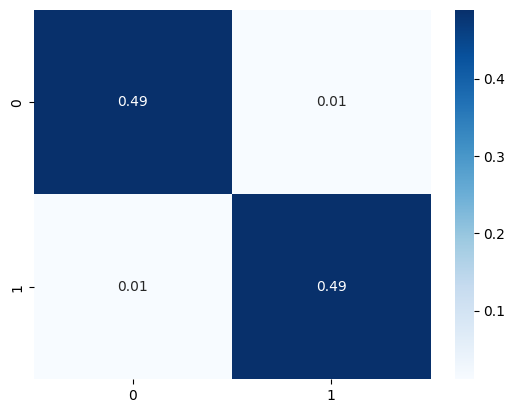

In [22]:
from sklearn.neighbors import KNeighborsClassifier

model_knn_pot = KNeighborsClassifier(n_neighbors=3)
model_knn_pot.fit(X_train_pot_scaled, y_train_pot)

y_pred_pot_knn = model_knn_pot.predict(X_test_pot_scaled)

print("Accuracy:", accuracy_score(y_test_pot, y_pred_pot_knn))

cf_pot_knn = confusion_matrix(y_test_pot, y_pred_pot_knn)
sns.heatmap(cf_pot_knn / np.sum(cf_pot_knn), annot=True, cmap='Blues', fmt='.2f')


6. LSTM

c:\Users\km307\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,682 (22.20 KB)

 Trainable params: 5,682 (22.20 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9260 - loss: 0.1793 - val_accuracy: 0.9677 - val_loss: 0.0772
Epoch 2/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9674 - loss: 0.0754 - val_accuracy: 0.9679 - val_loss: 0.0779
Epoch 3/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9676 - loss: 0.0736 - val_accuracy: 0.9674 - val_loss: 0.0728
Epoch 4/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9690 - loss: 0.0723 - val_accuracy: 0.9658 - val_loss: 0.0745
Epoch 5/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9690 - loss: 0.0703 - val_accuracy: 0.9657 - val_loss: 0.0754
Epoch 6/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9688 - loss: 0.0699 - val_accuracy: 0.9692 - val_loss: 0.0716
Epoch 7/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9684 - loss: 0.0712 - val_accuracy: 0.9683 - val_loss: 0.0712
Epoch 8/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9689 - loss: 0

Text(50.722222222222214, 0.5, 'Actual')

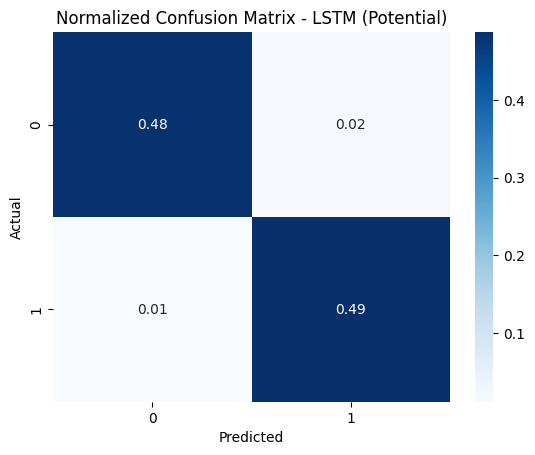

In [23]:

from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix

# --- Reshape the scaled input data for LSTM ---
X_train_lstm = X_train_pot_scaled.reshape((X_train_pot_scaled.shape[0], 1, X_train_pot_scaled.shape[1]))
X_test_lstm = X_test_pot_scaled.reshape((X_test_pot_scaled.shape[0], 1, X_test_pot_scaled.shape[1]))

# --- Convert labels to one-hot encoding ---
num_classes = len(np.unique(y_train_pot))
y_train_lstm = to_categorical(y_train_pot, num_classes=num_classes)
y_test_lstm = to_categorical(y_test_pot, num_classes=num_classes)

# --- Build LSTM model ---
model_lstm_pot = Sequential([
    LSTM(32, activation='relu', input_shape=(1, X_train_pot_scaled.shape[1])),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model_lstm_pot.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_lstm_pot.summary()

# --- Train the model ---
history_lstm_pot = model_lstm_pot.fit(X_train_lstm, y_train_lstm, epochs=20, 
                                      validation_data=(X_test_lstm, y_test_lstm), verbose=1)

# --- Predict and evaluate ---
y_pred_probs_pot = model_lstm_pot.predict(X_test_lstm)
y_pred_pot_lstm = np.argmax(y_pred_probs_pot, axis=1)
y_true_pot_lstm = np.argmax(y_test_lstm, axis=1)

# --- Accuracy and Confusion Matrix ---
print("LSTM Classifier Accuracy:", accuracy_score(y_true_pot_lstm, y_pred_pot_lstm))

cf_pot_lstm = confusion_matrix(y_true_pot_lstm, y_pred_pot_lstm)
sns.heatmap(cf_pot_lstm / np.sum(cf_pot_lstm), annot=True, cmap='Blues', fmt='.2f')
plt.title("Normalized Confusion Matrix - LSTM (Potential)")
plt.xlabel("Predicted")
plt.ylabel("Actual")


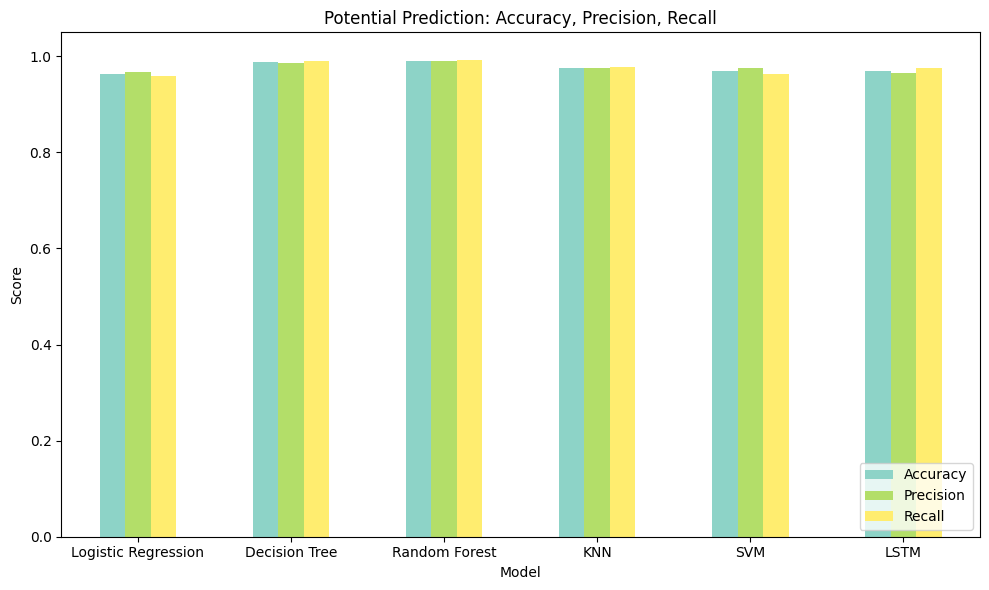

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pandas as pd
import matplotlib.pyplot as plt

metrics_pot = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'KNN', 'SVM', 'LSTM'],
    'Accuracy': [
        accuracy_score(y_test_pot, y_pred_pot_logreg),
        accuracy_score(y_test_pot, y_pred_pot_dt),
        accuracy_score(y_test_pot, y_pred_pot_rf),
        accuracy_score(y_test_pot, y_pred_pot_knn),
        accuracy_score(y_test_pot, y_pred_pot_svm),
        accuracy_score(y_test_pot, y_pred_pot_lstm)
    ],
    'Precision': [
        precision_score(y_test_pot, y_pred_pot_logreg, average='binary'),
        precision_score(y_test_pot, y_pred_pot_dt, average='binary'),
        precision_score(y_test_pot, y_pred_pot_rf, average='binary'),
        precision_score(y_test_pot, y_pred_pot_knn, average='binary'),
        precision_score(y_test_pot, y_pred_pot_svm, average='binary'),
        precision_score(y_test_pot, y_pred_pot_lstm, average='binary')
    ],
    'Recall': [
        recall_score(y_test_pot, y_pred_pot_logreg, average='binary'),
        recall_score(y_test_pot, y_pred_pot_dt, average='binary'),
        recall_score(y_test_pot, y_pred_pot_rf, average='binary'),
        recall_score(y_test_pot, y_pred_pot_knn, average='binary'),
        recall_score(y_test_pot, y_pred_pot_svm, average='binary'),
        recall_score(y_test_pot, y_pred_pot_lstm, average='binary')
    ]
}

# Create DataFrame for plotting
metrics_pot_df = pd.DataFrame(metrics_pot).set_index('Model')

# Plot
metrics_pot_df.plot(kind='bar', figsize=(10, 6), colormap='Set3')
plt.title("Potential Prediction: Accuracy, Precision, Recall")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()


# Regression -

For Generation -

In [27]:
# Select features and target for regression.
X_reg = combined_df[['latitude', 'longitude', 'area', 'elevation_m', 'resource']].values
y_reg = combined_df['capacity'].values

# Split the data.
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Scale the features.
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

1. Linear

In [28]:
from sklearn.linear_model import LinearRegression

model_lr = LinearRegression()
model_lr.fit(X_train_reg_scaled, y_train_reg)
y_pred_lr = model_lr.predict(X_test_reg_scaled)
print("Linear Regression MSE:", mean_squared_error(y_test_reg, y_pred_lr))
print("Linear Regression R^2:", r2_score(y_test_reg, y_pred_lr))

Linear Regression MSE: 167413.52826237722
Linear Regression R^2: 0.38673207772835627


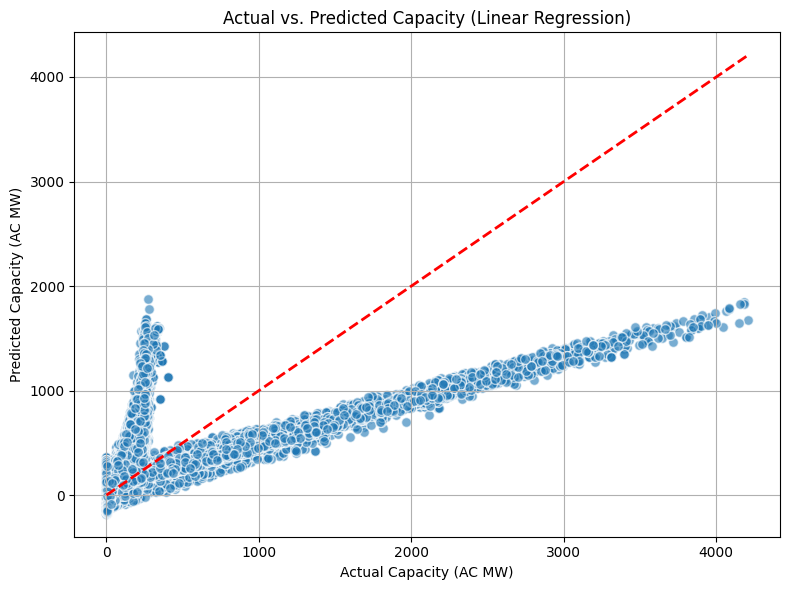

In [29]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_reg, y_pred_lr, alpha=0.6, edgecolors='w', s=50)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', linewidth=2)
plt.xlabel("Actual Capacity (AC MW)")
plt.ylabel("Predicted Capacity (AC MW)")
plt.title("Actual vs. Predicted Capacity (Linear Regression)")
plt.grid(True)
plt.tight_layout()
plt.show()


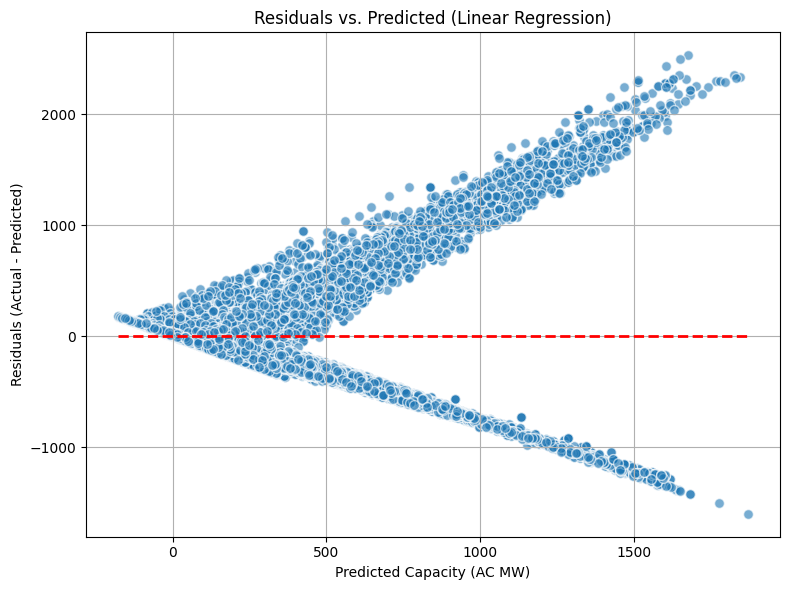

In [30]:
residuals = y_test_reg - y_pred_lr
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_lr, residuals, alpha=0.6, edgecolors='w', s=50)
plt.hlines(0, y_pred_lr.min(), y_pred_lr.max(), colors='r', linestyles='--', linewidth=2)
plt.xlabel("Predicted Capacity (AC MW)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs. Predicted (Linear Regression)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
from sklearn.tree import DecisionTreeRegressor

model_dt_reg = DecisionTreeRegressor(random_state=42)
model_dt_reg.fit(X_train_reg_scaled, y_train_reg)
y_pred_dt_reg = model_dt_reg.predict(X_test_reg_scaled)
print("Decision Tree Regression MSE:", mean_squared_error(y_test_reg, y_pred_dt_reg))
print("Decision Tree Regression R^2:", r2_score(y_test_reg, y_pred_dt_reg))


Decision Tree Regression MSE: 10341.41735973148
Decision Tree Regression R^2: 0.9621174011241976


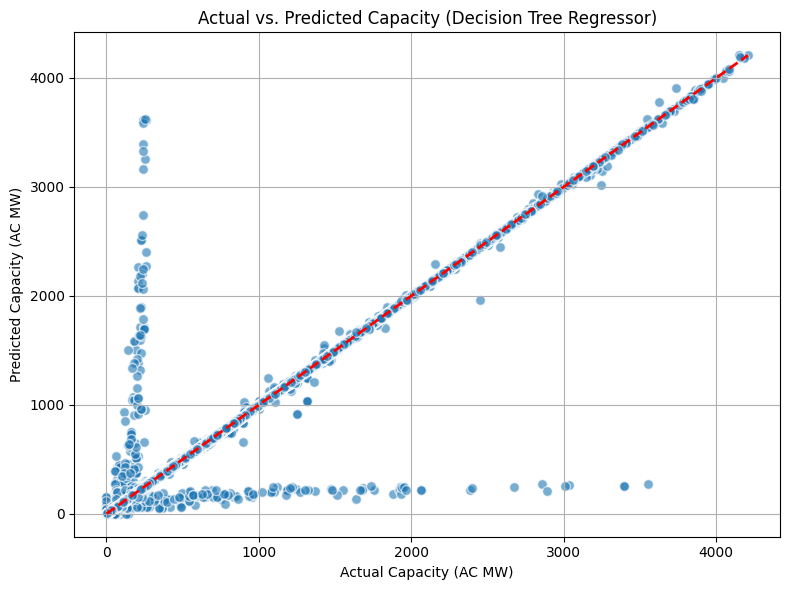

In [32]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_reg, y_pred_dt_reg, alpha=0.6, edgecolors='w', s=50)
plt.plot([y_test_reg.min(), y_test_reg.max()],
         [y_test_reg.min(), y_test_reg.max()],
         'r--', linewidth=2)
plt.xlabel("Actual Capacity (AC MW)")
plt.ylabel("Predicted Capacity (AC MW)")
plt.title("Actual vs. Predicted Capacity (Decision Tree Regressor)")
plt.grid(True)
plt.tight_layout()
plt.show()

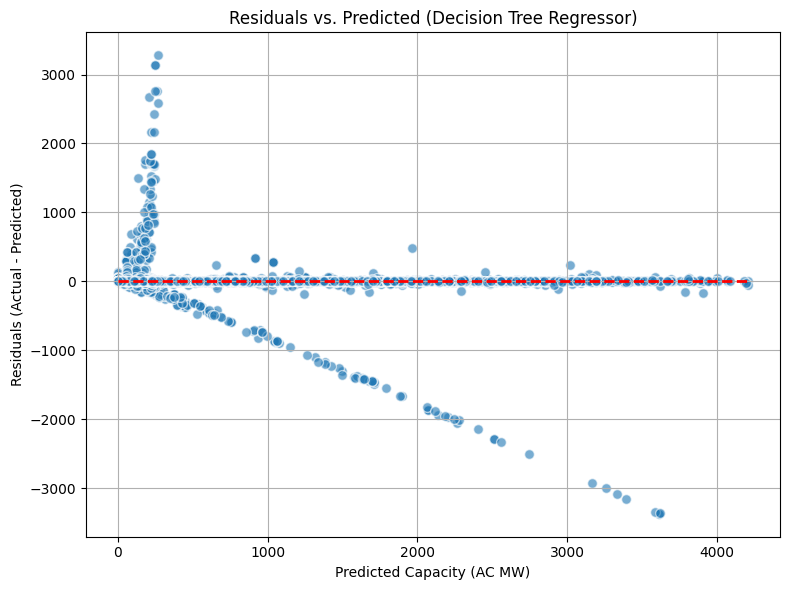

In [33]:
residuals_dt = y_test_reg - y_pred_dt_reg
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_dt_reg, residuals_dt, alpha=0.6, edgecolors='w', s=50)
plt.hlines(0, y_pred_dt_reg.min(), y_pred_dt_reg.max(), colors='r', linestyles='--', linewidth=2)
plt.xlabel("Predicted Capacity (AC MW)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs. Predicted (Decision Tree Regressor)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [34]:
from sklearn.ensemble import RandomForestRegressor

model_rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf_reg.fit(X_train_reg_scaled, y_train_reg)
y_pred_rf_reg = model_rf_reg.predict(X_test_reg_scaled)
print("Random Forest Regression MSE:", mean_squared_error(y_test_reg, y_pred_rf_reg))
print("Random Forest Regression R^2:", r2_score(y_test_reg, y_pred_rf_reg))


Random Forest Regression MSE: 5892.359464921338
Random Forest Regression R^2: 0.9784151550723751


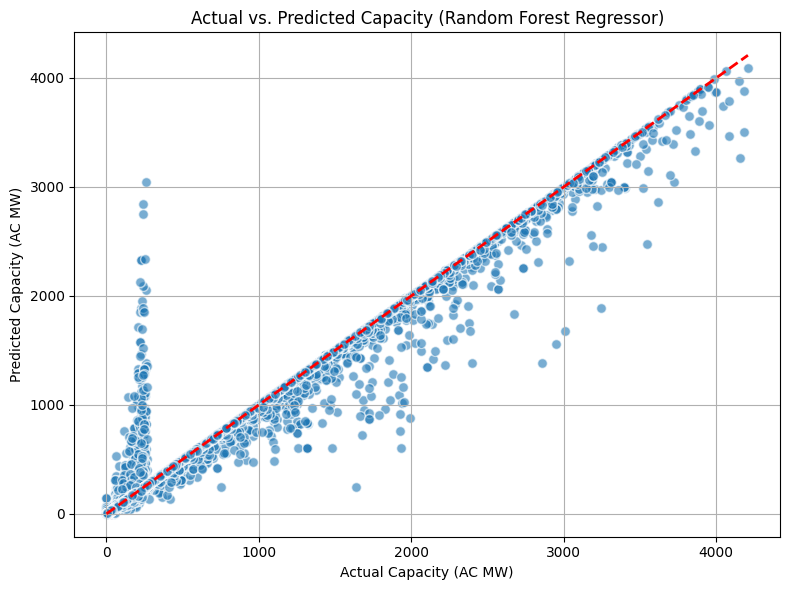

In [35]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_reg, y_pred_rf_reg, alpha=0.6, edgecolors='w', s=50)
plt.plot([y_test_reg.min(), y_test_reg.max()],
         [y_test_reg.min(), y_test_reg.max()],
         'r--', linewidth=2)
plt.xlabel("Actual Capacity (AC MW)")
plt.ylabel("Predicted Capacity (AC MW)")
plt.title("Actual vs. Predicted Capacity (Random Forest Regressor)")
plt.grid(True)
plt.tight_layout()
plt.show()

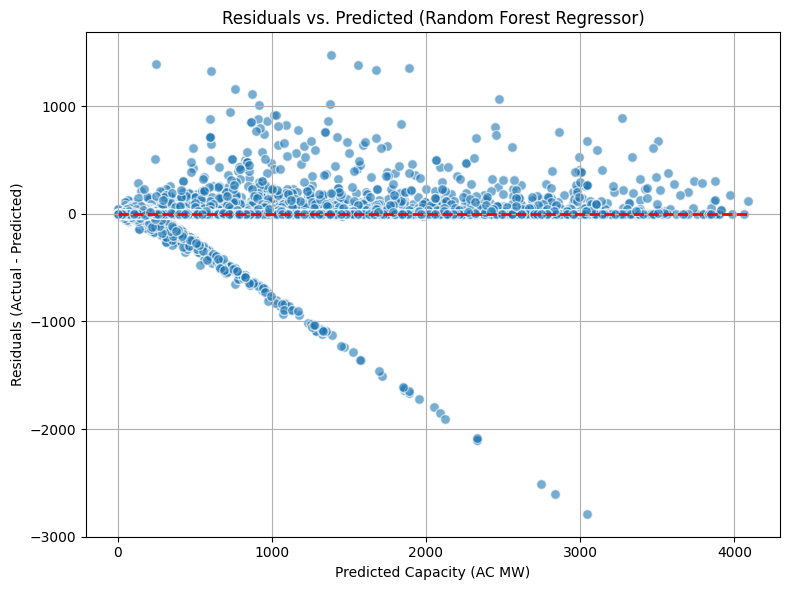

In [36]:
residuals_rf = y_test_reg - y_pred_rf_reg
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_rf_reg, residuals_rf, alpha=0.6, edgecolors='w', s=50)
plt.hlines(0, y_pred_rf_reg.min(), y_pred_rf_reg.max(), colors='r', linestyles='--', linewidth=2)
plt.xlabel("Predicted Capacity (AC MW)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs. Predicted (Random Forest Regressor)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score

# --- Reshape for LSTM (requires 3D input: [samples, timesteps, features]) ---
X_train_lstm = X_train_reg_scaled.reshape((X_train_reg_scaled.shape[0], 1, X_train_reg_scaled.shape[1]))
X_test_lstm = X_test_reg_scaled.reshape((X_test_reg_scaled.shape[0], 1, X_test_reg_scaled.shape[1]))

# --- Build LSTM model for regression ---
model_lstm_reg = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(1)  # Single continuous output
])

model_lstm_reg.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
model_lstm_reg.summary()

# --- Train the model ---
history_lstm_reg = model_lstm_reg.fit(X_train_lstm, y_train_reg, epochs=20, 
                                      validation_data=(X_test_lstm, y_test_reg), verbose=1)

# --- Predict and evaluate ---
y_pred_lstm_reg = model_lstm_reg.predict(X_test_lstm).flatten()

print("LSTM Regression MSE:", mean_squared_error(y_test_reg, y_pred_lstm_reg))
print("LSTM Regression R^2:", r2_score(y_test_reg, y_pred_lstm_reg))


c:\Users\km307\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,251 (43.95 KB)

 Trainable params: 11,251 (43.95 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 106639.7188 - val_loss: 36818.9883
Epoch 2/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 34050.9766 - val_loss: 30724.7324
Epoch 3/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 29607.7832 - val_loss: 27024.8086
Epoch 4/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 26164.2480 - val_loss: 24470.0098
Epoch 5/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 25035.6953 - val_loss: 22760.3613
Epoch 6/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 22813.3027 - val_loss: 21105.3789
Epoch 7/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 22919.8105 - val_loss: 19868.8594
Epoch 8/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 21239.4316 - val_loss: 20300.4219
Epoch 9/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 20397.0273 - val_loss: 18587.0000
Epoch 10/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 20603.3906 - val_loss: 19695.6328
Epoch 11/20
4500/4500 ━━━━━━

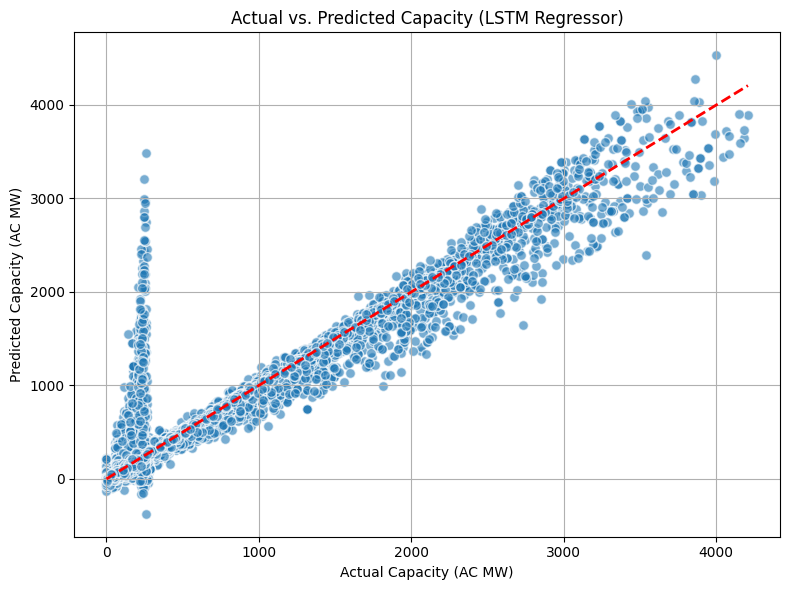

In [38]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_reg, y_pred_lstm_reg, alpha=0.6, edgecolors='w', s=50)
plt.plot([y_test_reg.min(), y_test_reg.max()],
         [y_test_reg.min(), y_test_reg.max()],
         'r--', linewidth=2)
plt.xlabel("Actual Capacity (AC MW)")
plt.ylabel("Predicted Capacity (AC MW)")
plt.title("Actual vs. Predicted Capacity (LSTM Regressor)")
plt.grid(True)
plt.tight_layout()
plt.show()


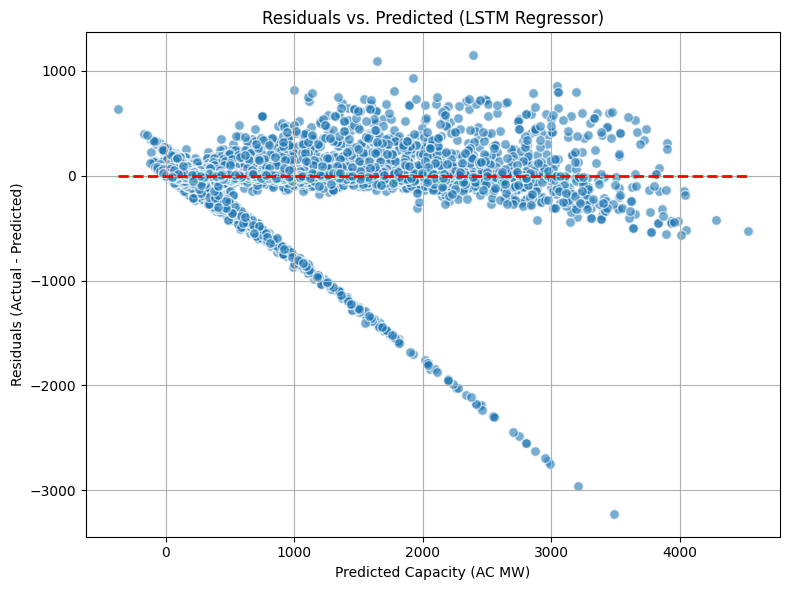

In [39]:
residuals_lstm = y_test_reg - y_pred_lstm_reg
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_lstm_reg, residuals_lstm, alpha=0.6, edgecolors='w', s=50)
plt.hlines(0, y_pred_lstm_reg.min(), y_pred_lstm_reg.max(), colors='r', linestyles='--', linewidth=2)
plt.xlabel("Predicted Capacity (AC MW)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs. Predicted (LSTM Regressor)")
plt.grid(True)
plt.tight_layout()
plt.show()


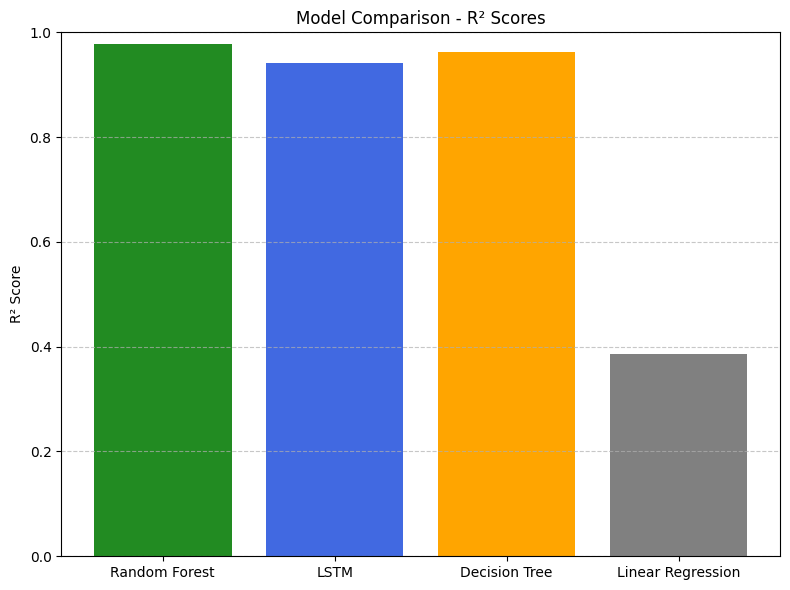

In [40]:
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score


r2_rf_reg = r2_score(y_test_reg, y_pred_rf_reg)
r2_lstm_reg = r2_score(y_test_reg, y_pred_lstm_reg)
r2_dt_reg = r2_score(y_test_reg, y_pred_dt_reg)
r2_lr_reg = r2_score(y_test_reg, y_pred_lr)

r2_scores = {
    'Random Forest': r2_rf_reg,
    'LSTM': r2_lstm_reg,
    'Decision Tree': r2_dt_reg,
    'Linear Regression': r2_lr_reg
}

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(r2_scores.keys(), r2_scores.values(), color=['forestgreen', 'royalblue', 'orange', 'gray'])
plt.title("Model Comparison - R² Scores")
plt.ylabel("R² Score")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### For Consumption -

In [16]:
cons_df = pd.read_excel('US_Prod_and_Cons.xlsx')
print("Initial Data:")
cons_df.head()

Initial Data:


Month  Total Renewable Energy Production  \
0 1973-01-01                            219.839   
1 1973-02-01                            197.330   
2 1973-03-01                            218.686   
3 1973-04-01                            209.330   
4 1973-05-01                            215.982   

   Hydroelectric Power Consumption Solar Energy Consumption  \
0                           89.562            Not Available   
1                           79.544            Not Available   
2                           88.284            Not Available   
3                           83.152            Not Available   
4                           85.643            Not Available   

  Wind Energy Consumption  Total Renewable Energy Consumption  
0           Not Available                             219.839  
1           Not Available                             197.330  
2           Not Available                             218.686  
3           Not Available                             209.330  
4           Not Available                             215.982


Data after setting datetime index:


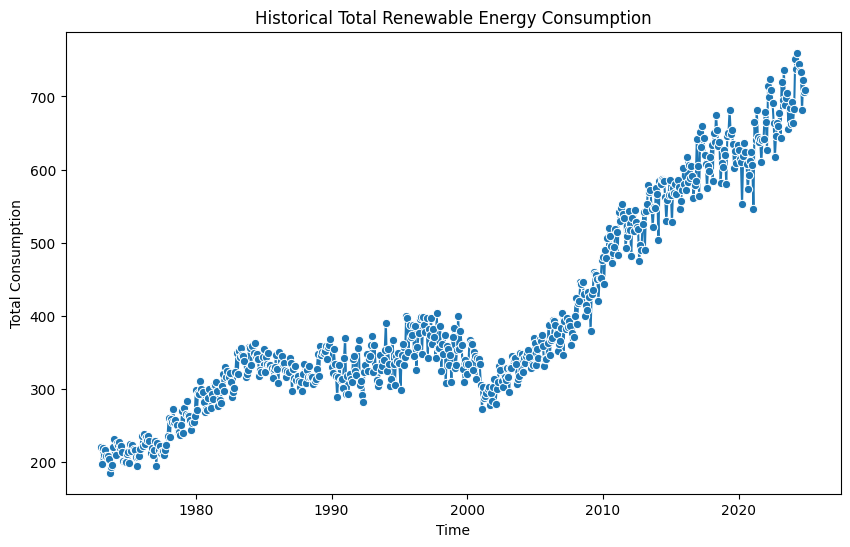

In [17]:
cons_df['Month'] = pd.to_datetime(cons_df['Month'], format='%Y %B')
cons_df = cons_df.set_index('Month')
cons_df.sort_index(inplace=True)

print("\nData after setting datetime index:")
cons_df.head()

# Visualize the Total Renewable Energy Consumption
plt.figure(figsize=(10, 6))
sns.lineplot(data=cons_df, x=cons_df.index, y="Total Renewable Energy Consumption", marker='o')
plt.title("Historical Total Renewable Energy Consumption")
plt.xlabel("Time")
plt.ylabel("Total Consumption")
plt.show()

## Forecasting Using Arima

In [ ]:
# Using ARIMA on Total Renewable Energy Consumption
series = cons_df["Total Renewable Energy Consumption"]
model = ARIMA(series, order=(1, 1, 1))
model_fit = model.fit()

# Forecast the next 3 periods (months in this case)
forecast_steps = 3
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_df = forecast.summary_frame()

# Create forecast index: assuming monthly frequency
last_date = cons_df.index[-1]
forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')
forecast_df.index = forecast_index

print("Forecasted values:")
print(forecast_df[['mean', 'mean_ci_lower', 'mean_ci_upper']])


c:\Users\km307\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\km307\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\km307\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecasted values:
Total Renewable Energy Consumption        mean  mean_ci_lower  mean_ci_upper
2025-01-01                          712.870399     669.630936     756.109861
2025-02-01                          713.648057     666.376657     760.919456
2025-03-01                          713.804348     664.431104     763.177591


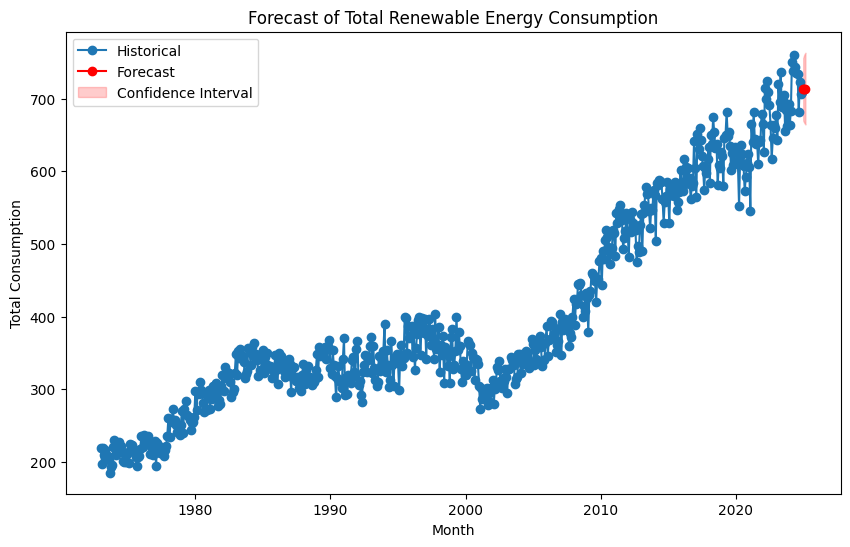

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(cons_df.index, series, label='Historical', marker='o')
plt.plot(forecast_df.index, forecast_df['mean'], label='Forecast', marker='o', color='red')
plt.fill_between(forecast_df.index, forecast_df['mean_ci_lower'], forecast_df['mean_ci_upper'],
                 color='red', alpha=0.2, label='Confidence Interval')
plt.title("Forecast of Total Renewable Energy Consumption")
plt.xlabel("Month")
plt.ylabel("Total Consumption")
plt.legend()

In [5]:
cons_df.reset_index(drop=True, inplace=True)

# Create a numeric time index for modeling
cons_df['month_idx'] = np.arange(len(cons_df))

XGBoost Mean Squared Error: 5989.33
XGBoost R² Score: -1.19


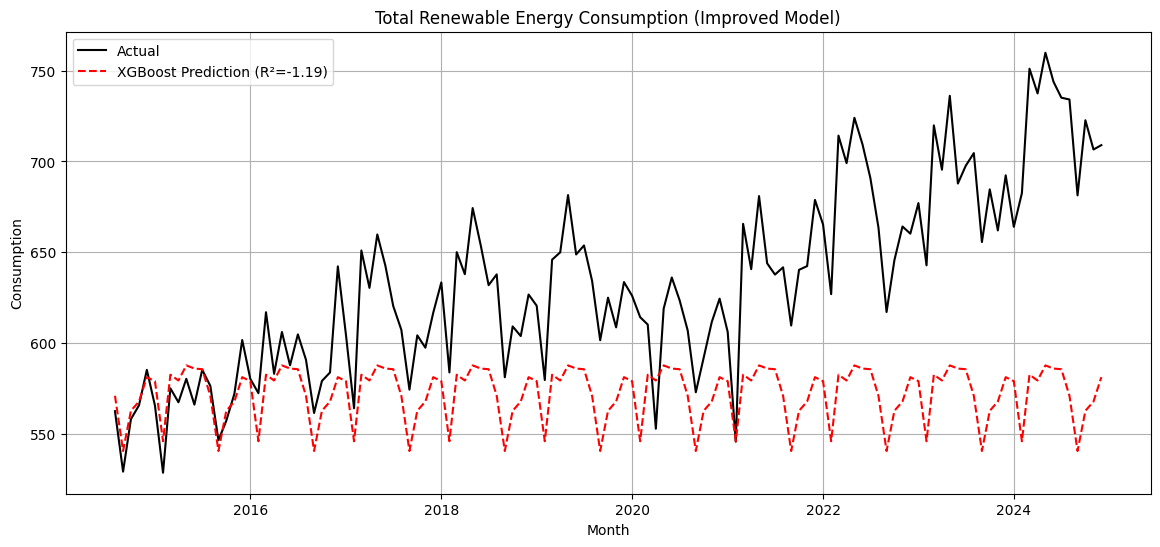

In [ ]:
from xgboost import XGBRegressor


cons_df = pd.read_excel('US_Prod_and_Cons.xlsx')
cons_df['Month'] = pd.to_datetime(cons_df['Month'])

# --- Feature Engineering ---
cons_df['month_idx'] = np.arange(len(cons_df))
cons_df['Year'] = cons_df['Month'].dt.year
cons_df['Month_Num'] = cons_df['Month'].dt.month
cons_df['Month_sin'] = np.sin(2 * np.pi * cons_df['Month_Num'] / 12)
cons_df['Month_cos'] = np.cos(2 * np.pi * cons_df['Month_Num'] / 12)

# --- Define Features and Target ---
X = cons_df[['month_idx', 'Year', 'Month_sin', 'Month_cos']].values
y = cons_df['Total Renewable Energy Consumption'].values

# --- Train-Test Split ---
split = int(len(cons_df) * 0.8)  # 80% train, 20% test
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
months_test = cons_df['Month'][split:]

# --- Train XGBoost Model ---
model_xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)
model_xgb.fit(X_train, y_train)

# --- Predict ---
y_pred_xgb = model_xgb.predict(X_test)

# --- Evaluation ---
mse = mean_squared_error(y_test, y_pred_xgb)
r2 = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Mean Squared Error: {mse:.2f}")
print(f"XGBoost R² Score: {r2:.2f}")

# --- Plot Results ---
plt.figure(figsize=(14,6))
plt.plot(months_test, y_test, label='Actual', color='black')
plt.plot(months_test, y_pred_xgb, '--', label=f'XGBoost Prediction (R²={r2:.2f})', color='red')
plt.title('Total Renewable Energy Consumption (Improved Model)')
plt.xlabel('Month')
plt.ylabel('Consumption')
plt.legend()
plt.grid()

